In [1]:
import os, warnings
from pathlib import Path

import anndata as ad
import numpy as np
import dynamo as dyn
import spateo as st
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

2023-10-02 17:29:16.549745: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 17:29:16.570861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 17:29:16.891227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid, UniformGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

## Load the data

In [3]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer_new")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_image_path = f"image/review_predicted_path"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [4]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_germband_v4.h5ad")
for i, k in enumerate(["V_x", "V_y", "V_z"]):
    germ_adata.obs[k] = germ_adata.uns["VecFld_morpho"]["V"][:, i].flatten()
germ_pc = st.tdr.read_model(f"morpho_models/germband_morphometrics_pc_model.vtk")
germ_mesh = st.tdr.read_model(f"morpho_models/germband_morphometrics_mesh_model.vtk")
trajectory_model = st.tdr.read_model(f"morpho_models/germband_morphofield_trajectory_model.vtk")
germ_adata

AnnData object with n_obs × n_vars = 12585 × 8120
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion', 'V_x', 'V_y'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## Predicted path of germband

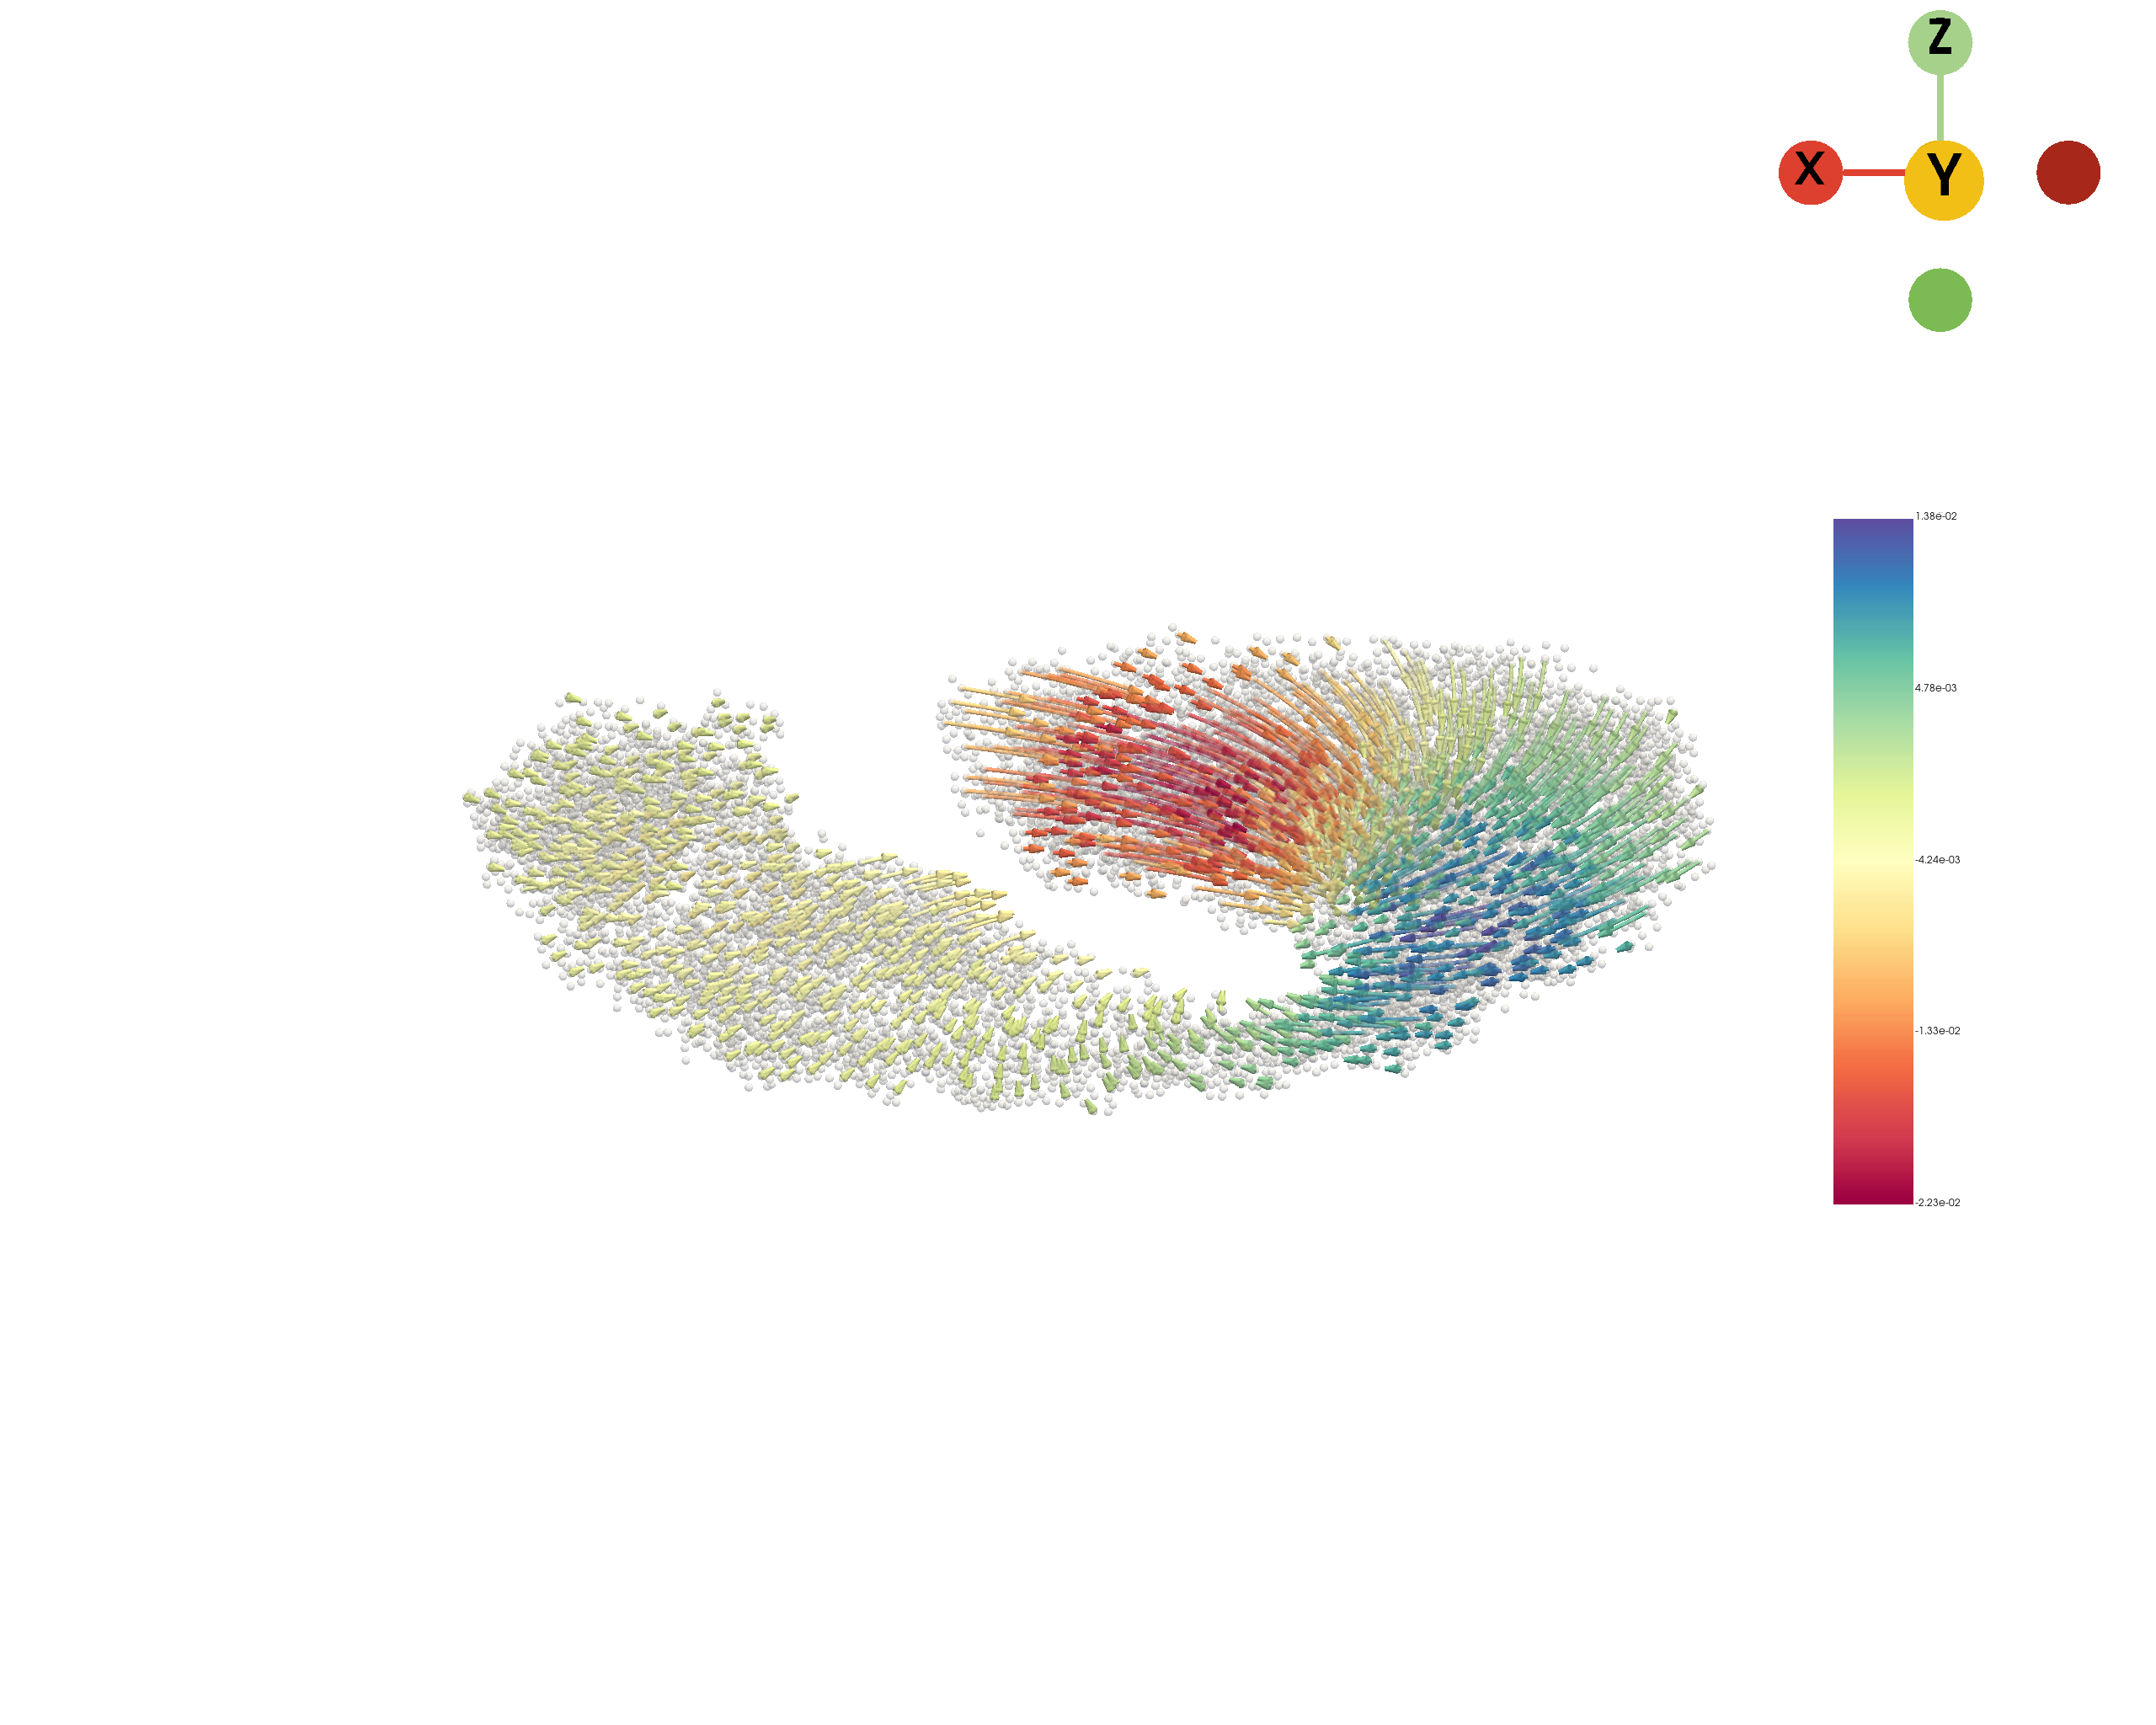

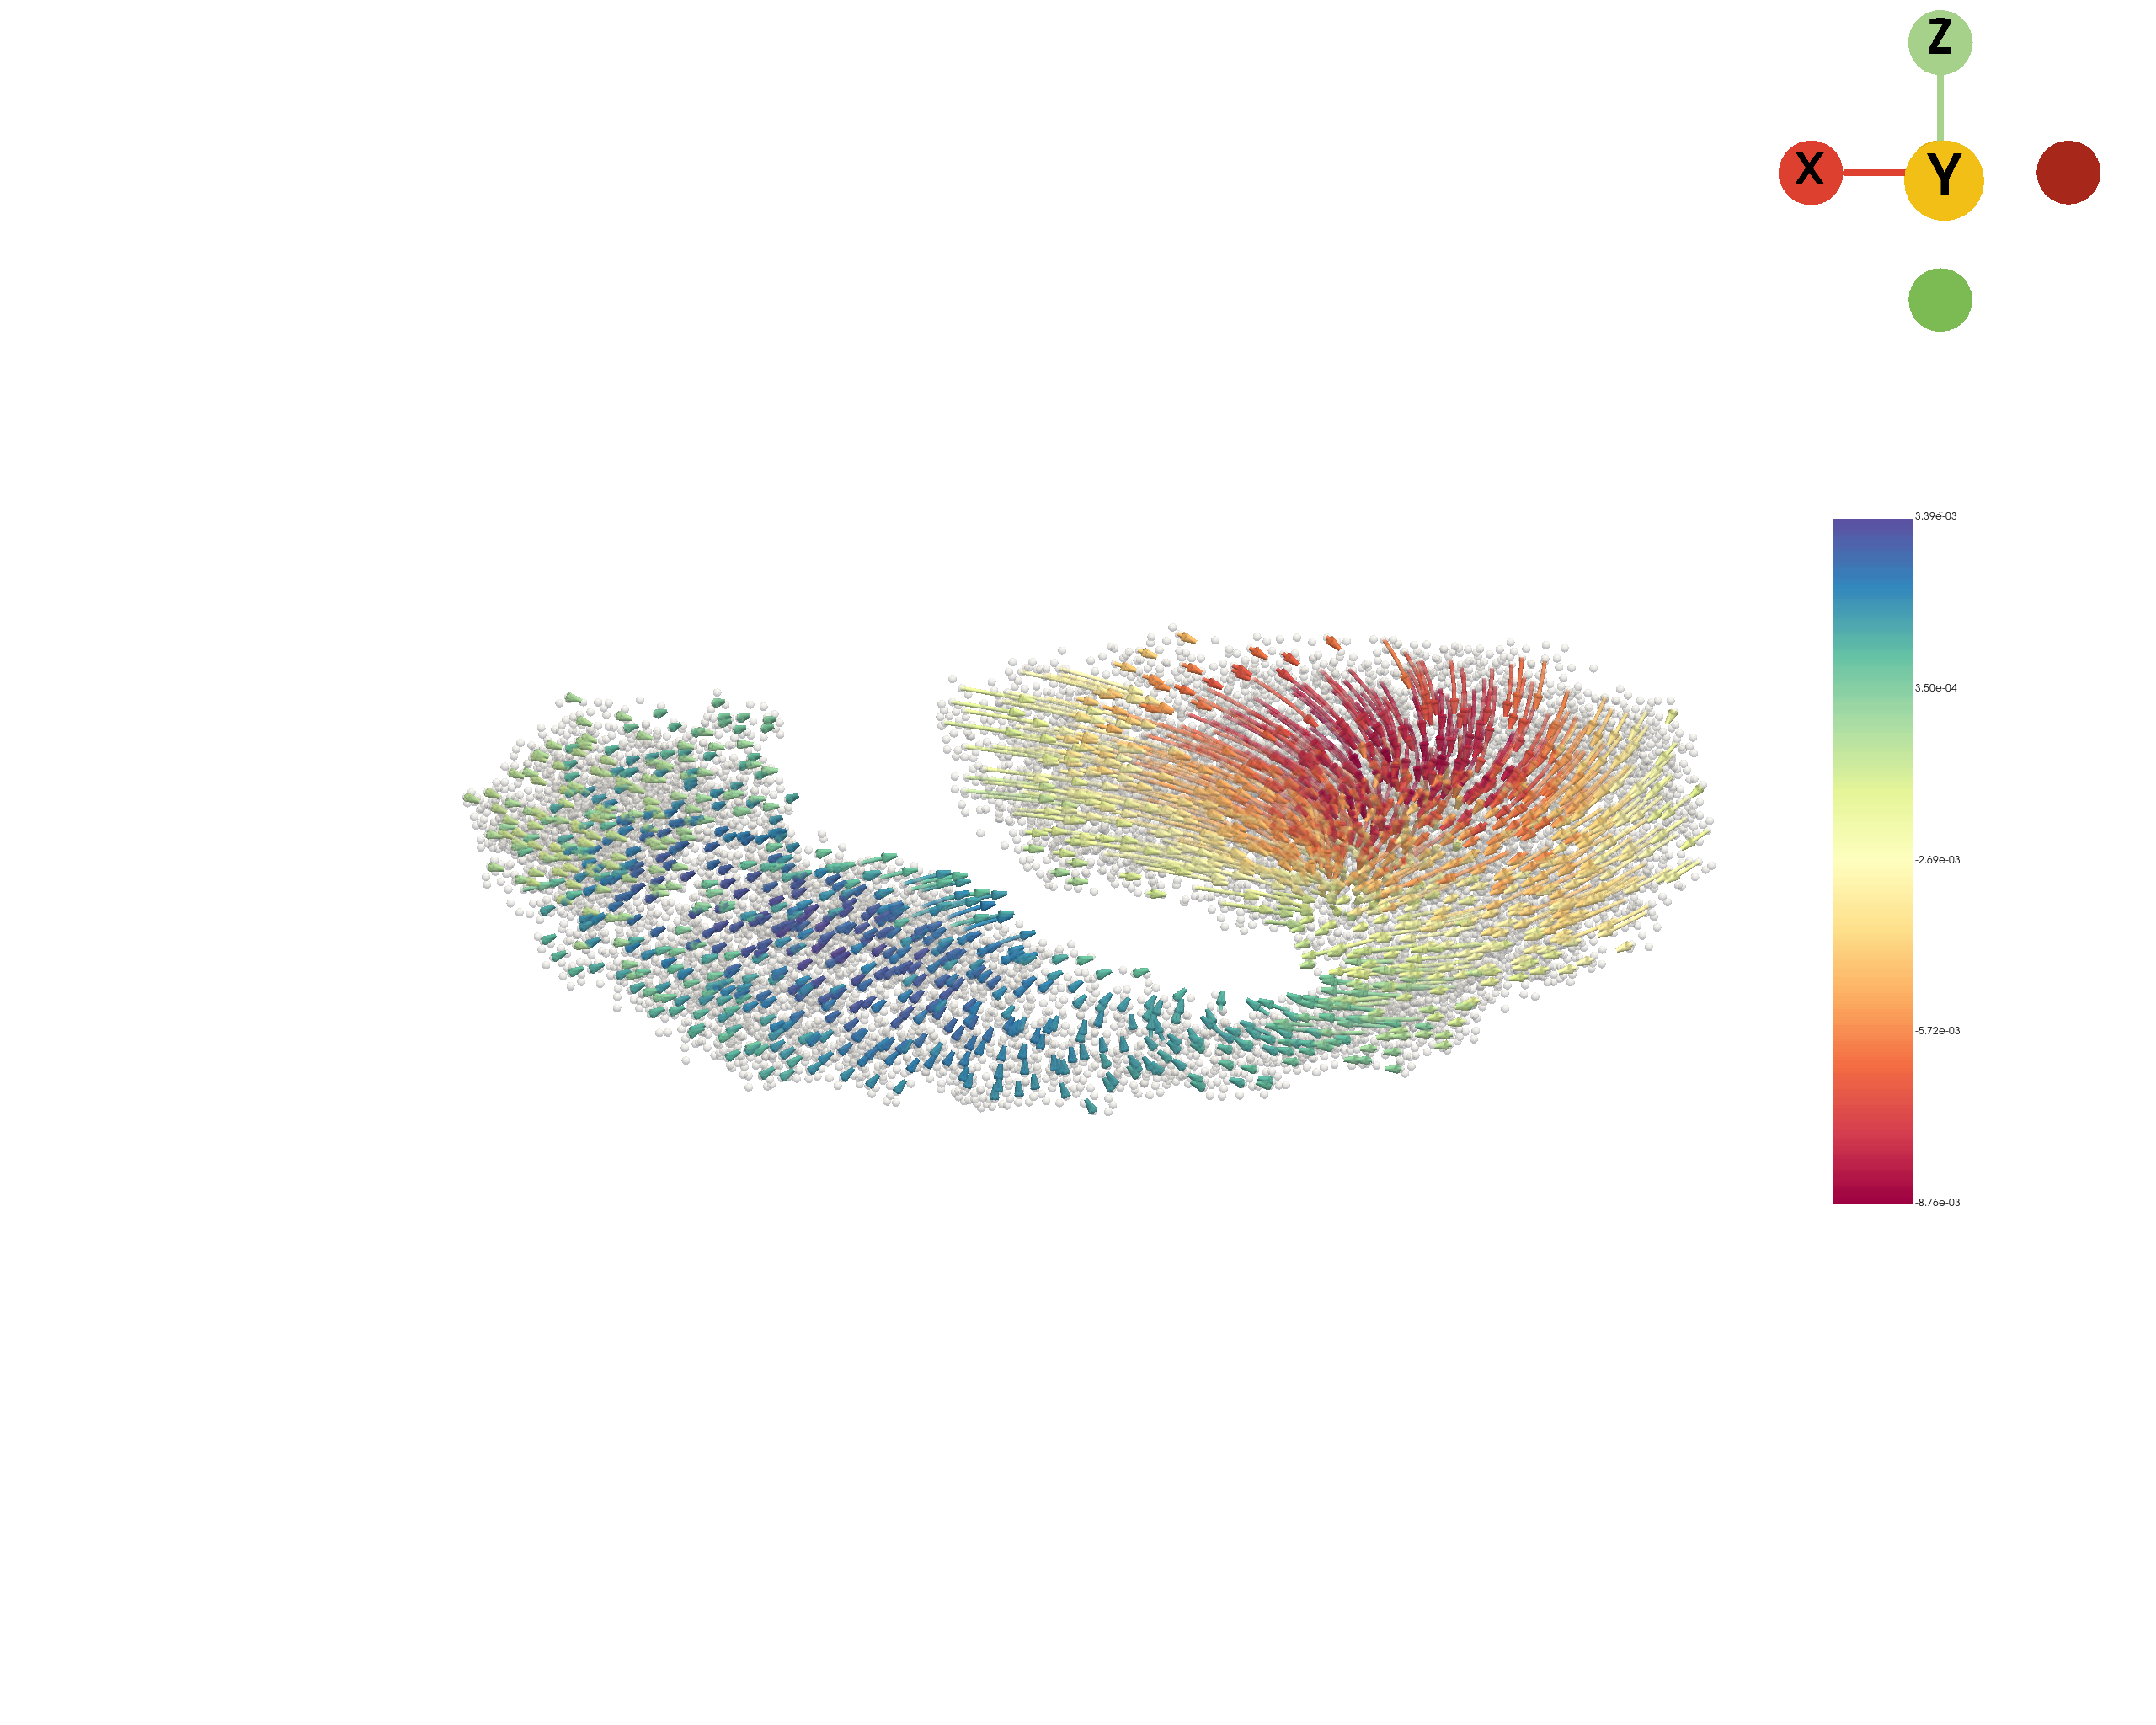

In [5]:
for k in ["V_x", "V_z"]:
    st.tdr.add_model_labels(
        model=trajectory_model,
        key_added="trajectory",
        labels=np.asarray(germ_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[k]),
        where="point_data",
        inplace=True,
    )
    st.pl.three_d_plot(
        model=st.tdr.collect_models([germ_pc, trajectory_model]),
        key=["tissue", "trajectory"],
        opacity=[0.5, .5],
        model_style=["points", "wireframe"],
        model_size=[10, 5],
        colormap=["gainsboro", "Spectral"],
        jupyter="static",
        background="white",
        window_size=(2560, 2048),
        cpo=cpo,
        filename=os.path.join(out_image_path, f"germband_morphofield_trajectory_pc_model_{k}.pdf")
    )

## Predicted path of each tissue

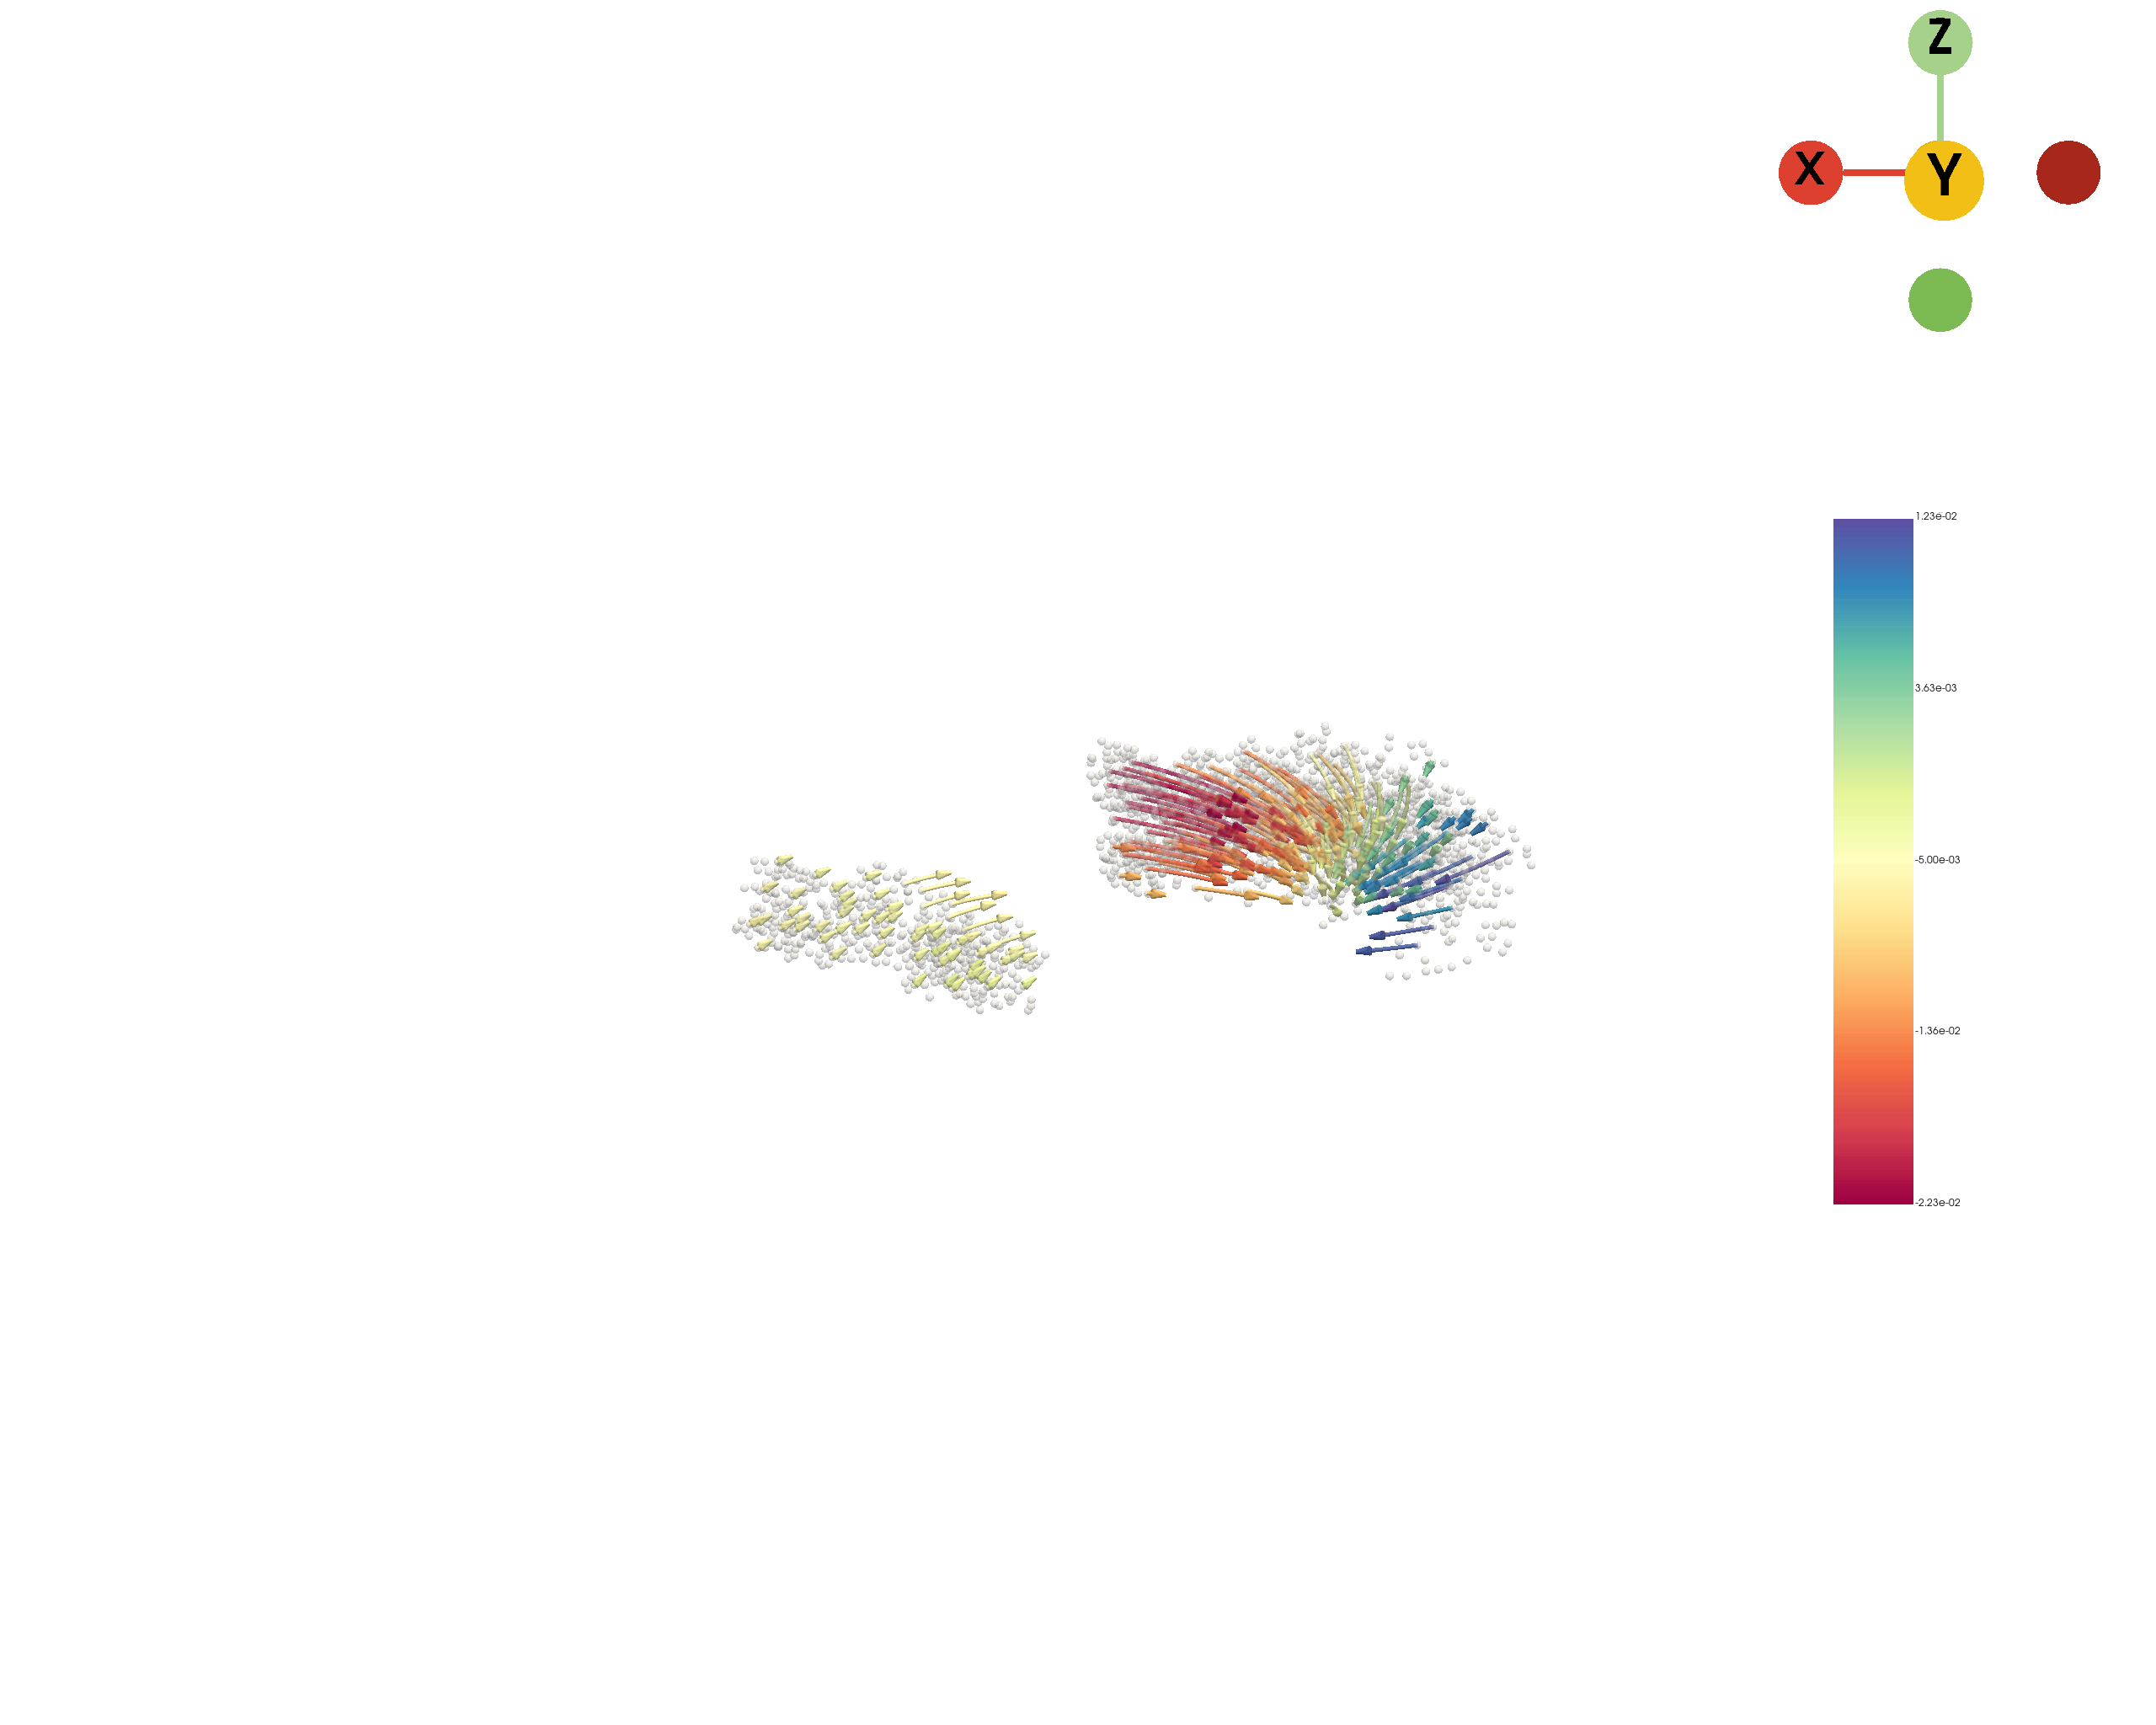

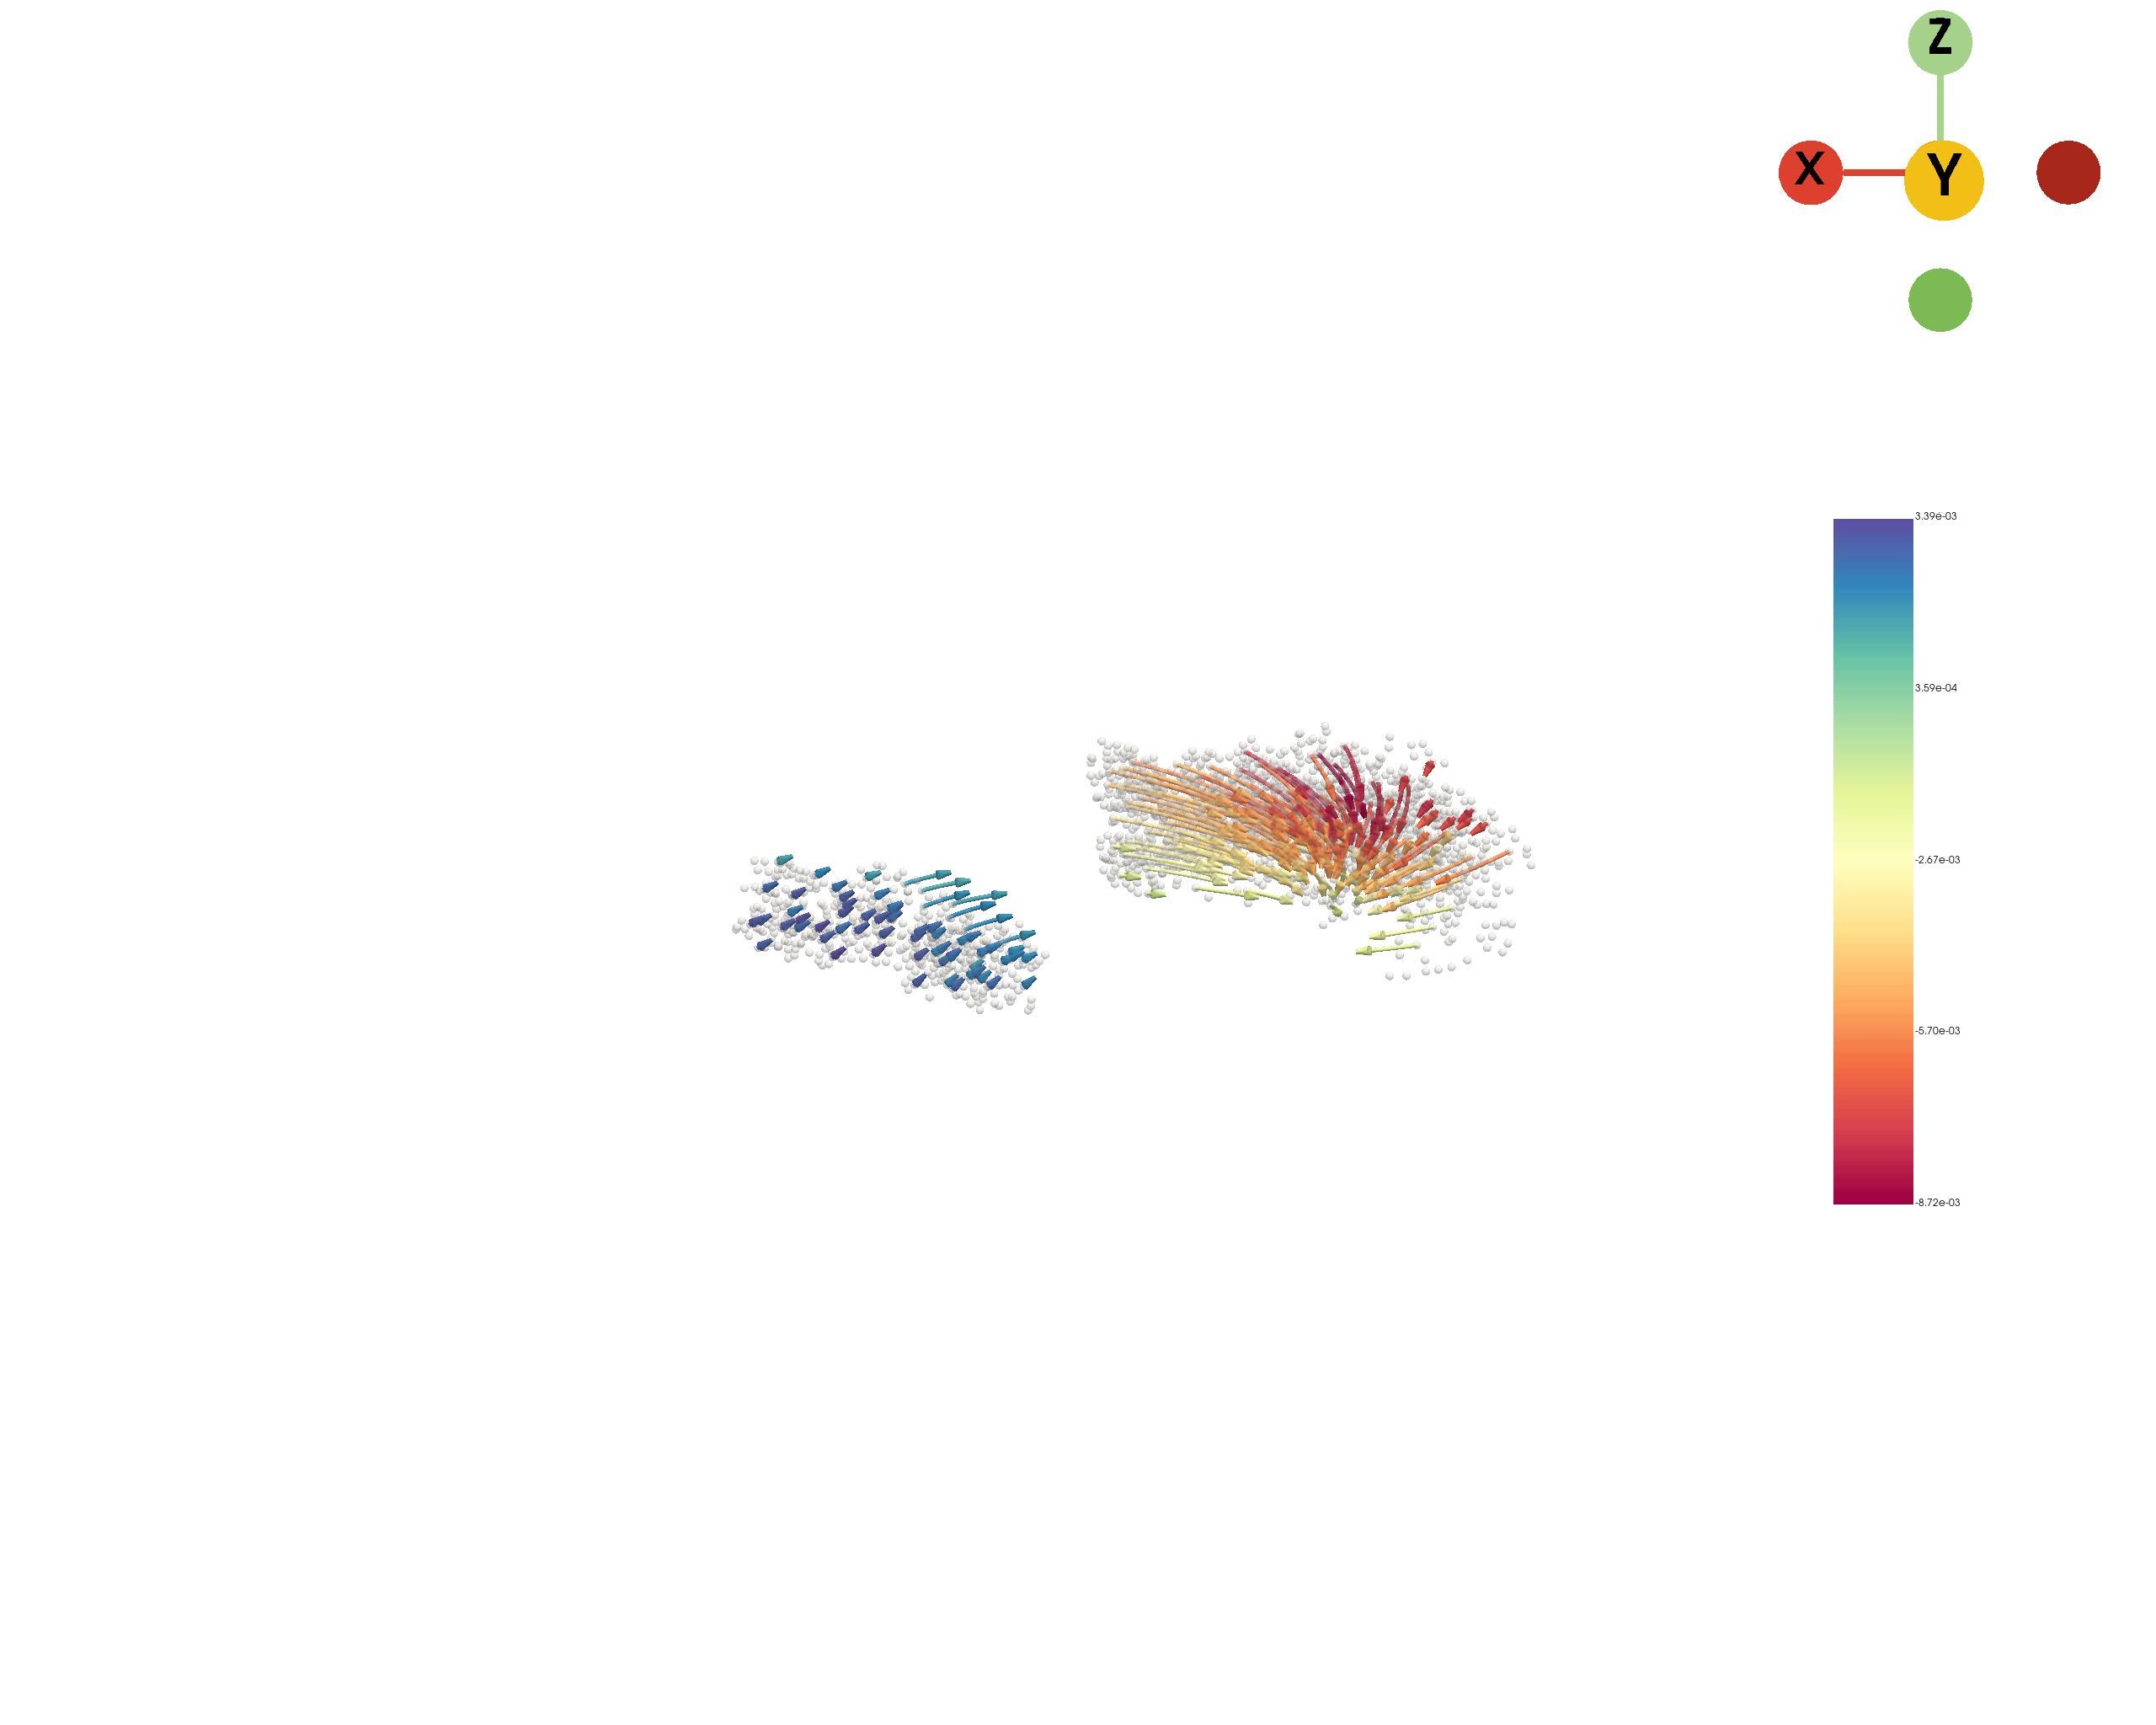

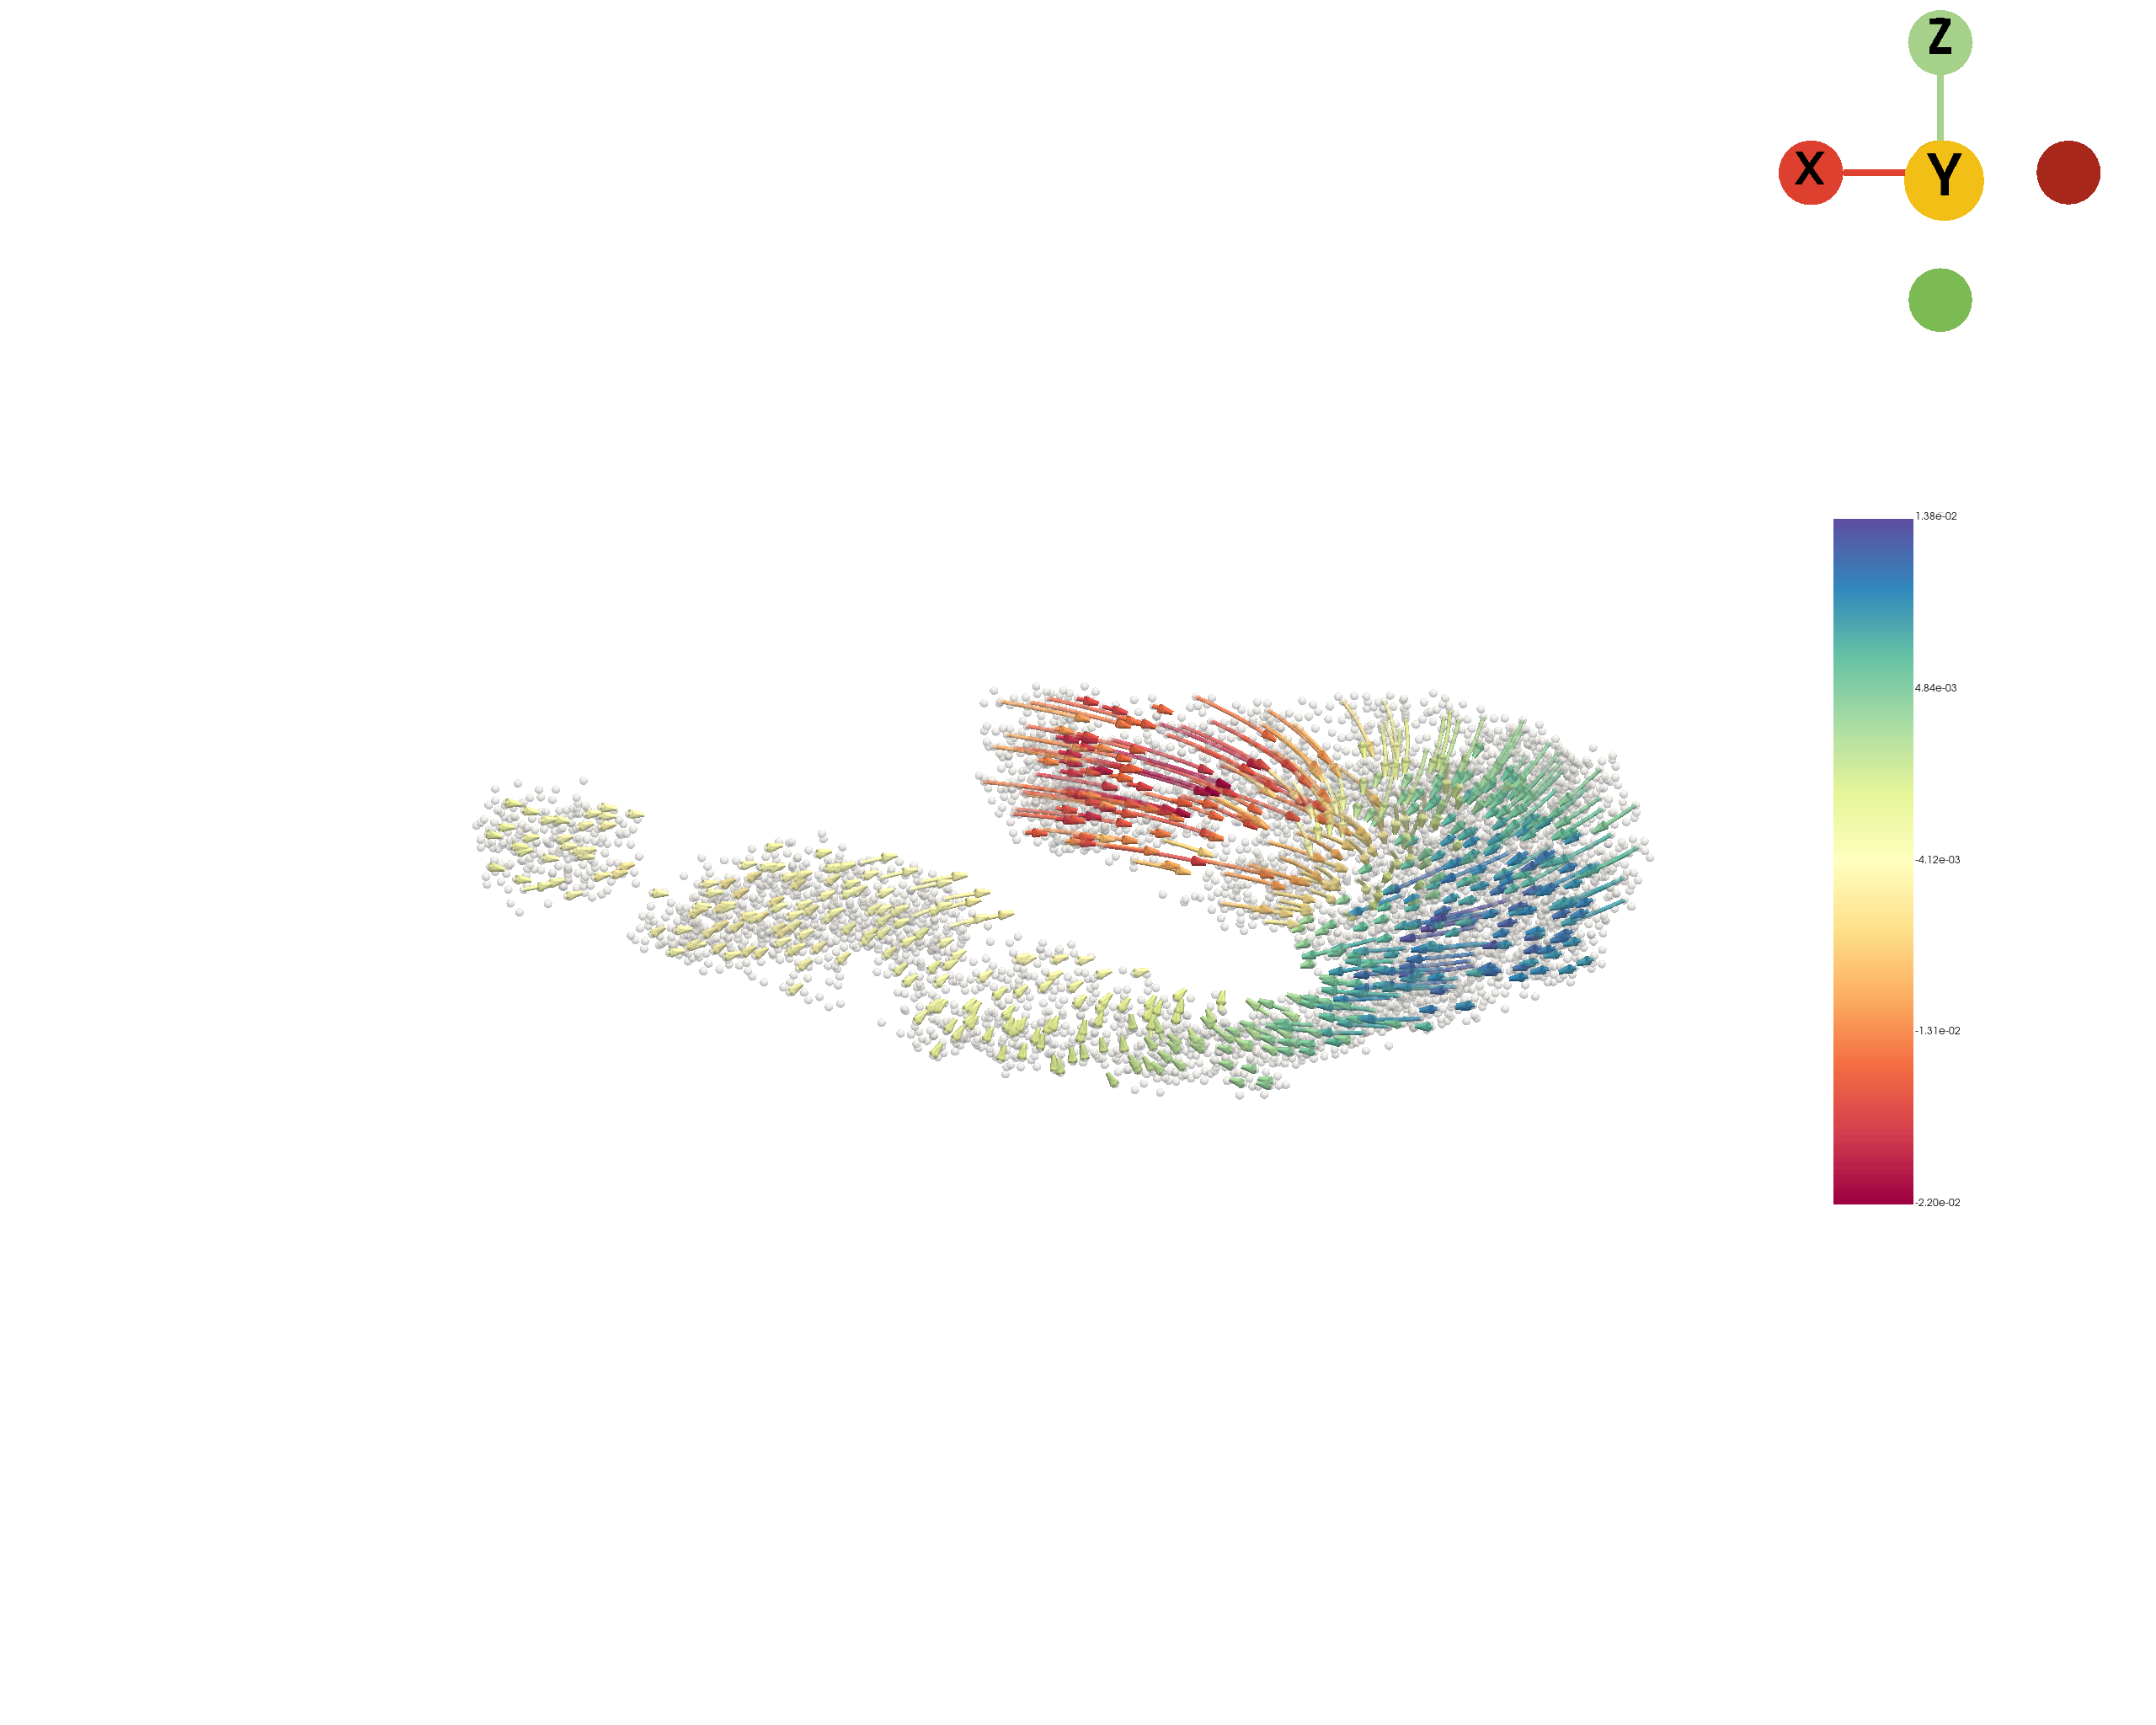

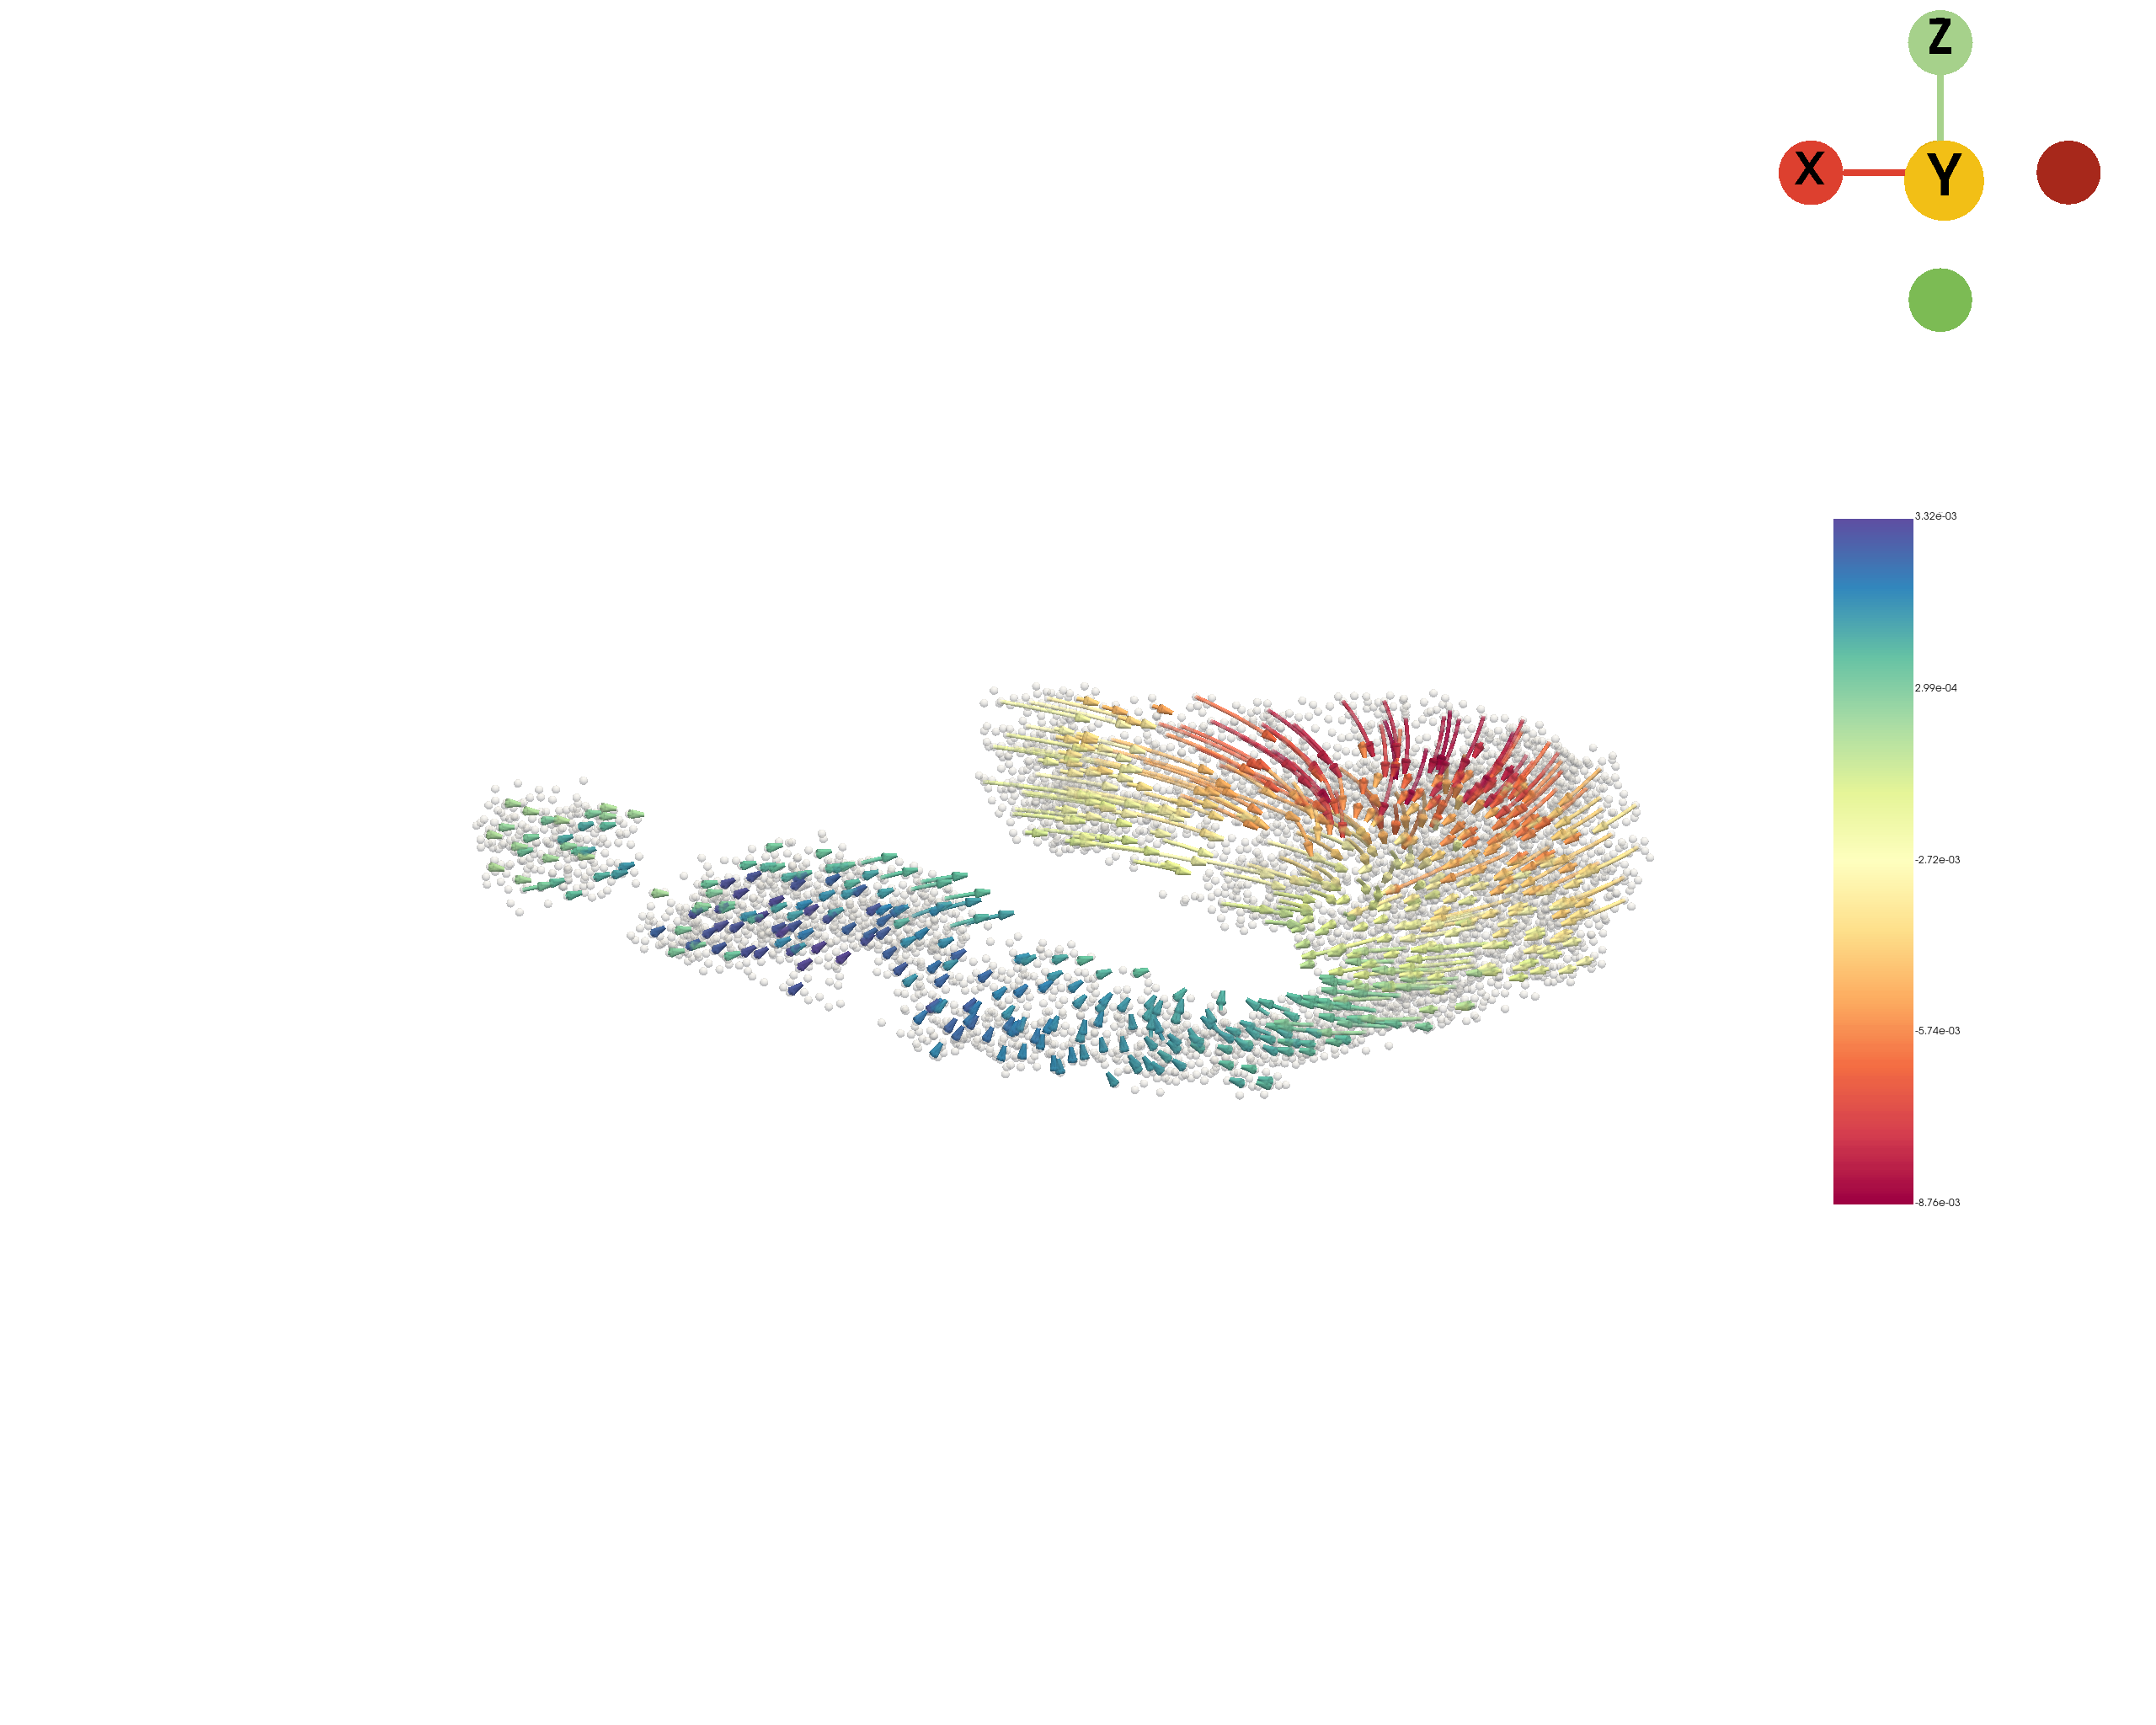

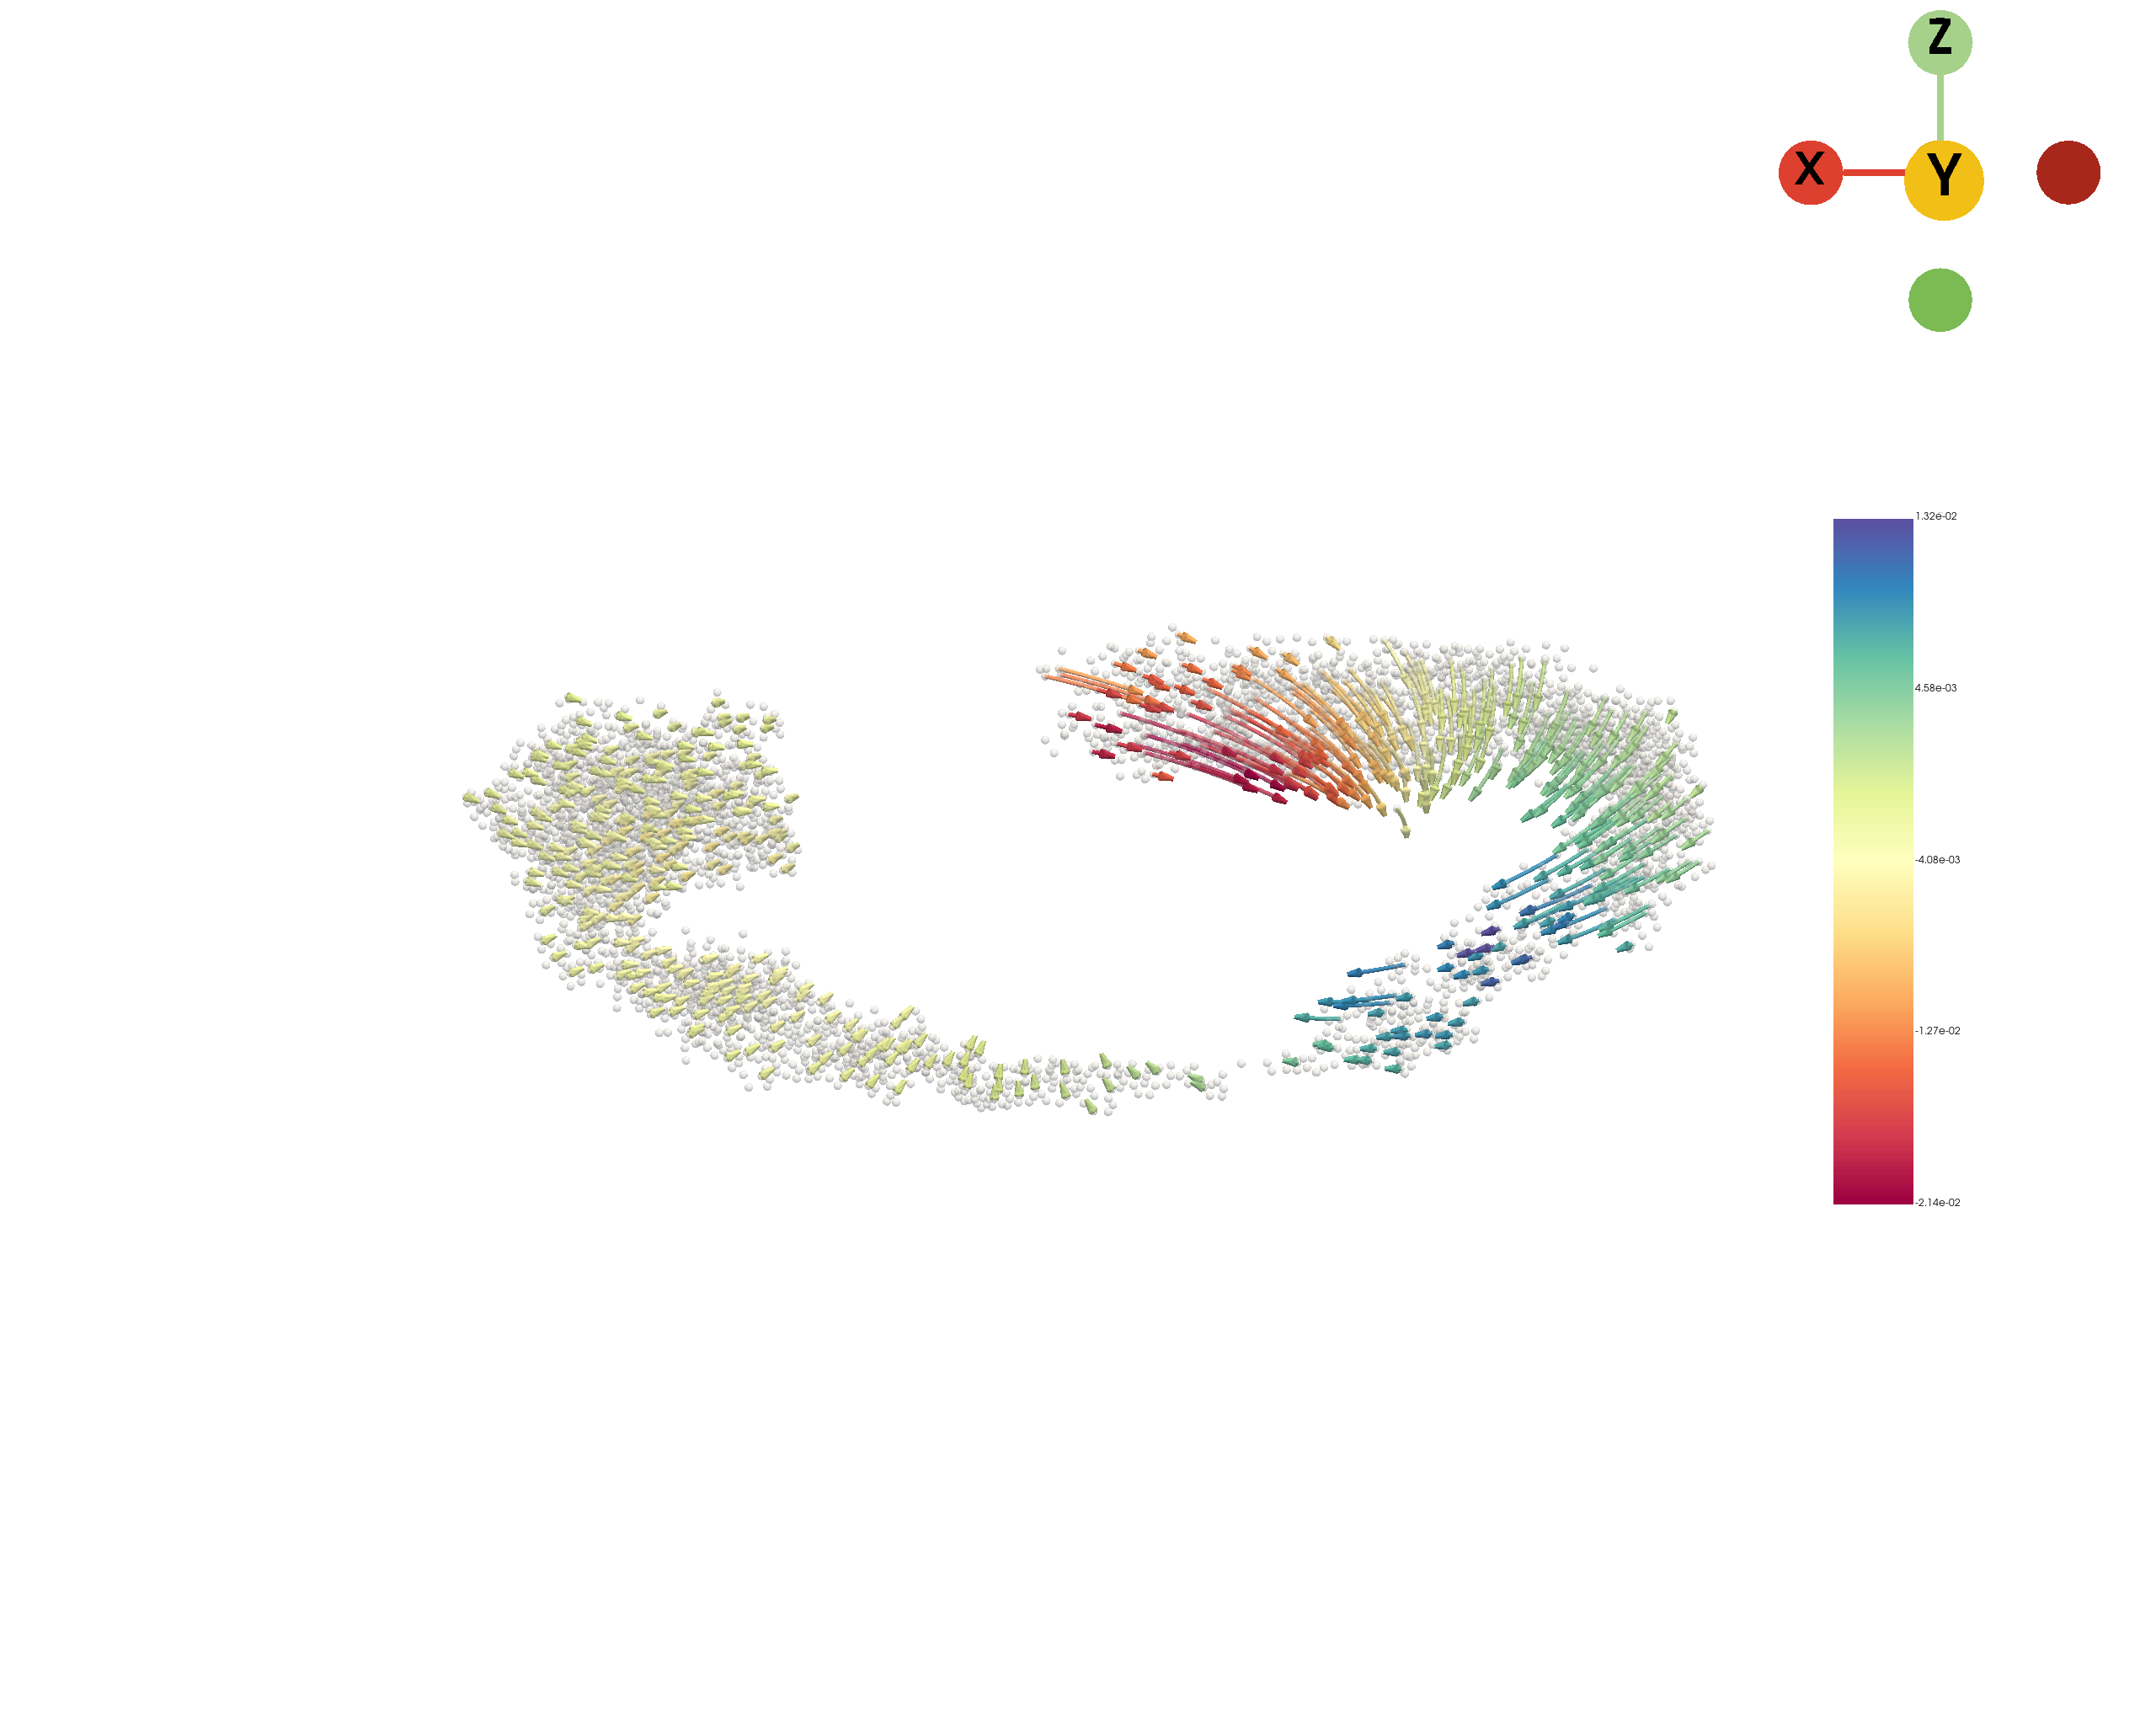

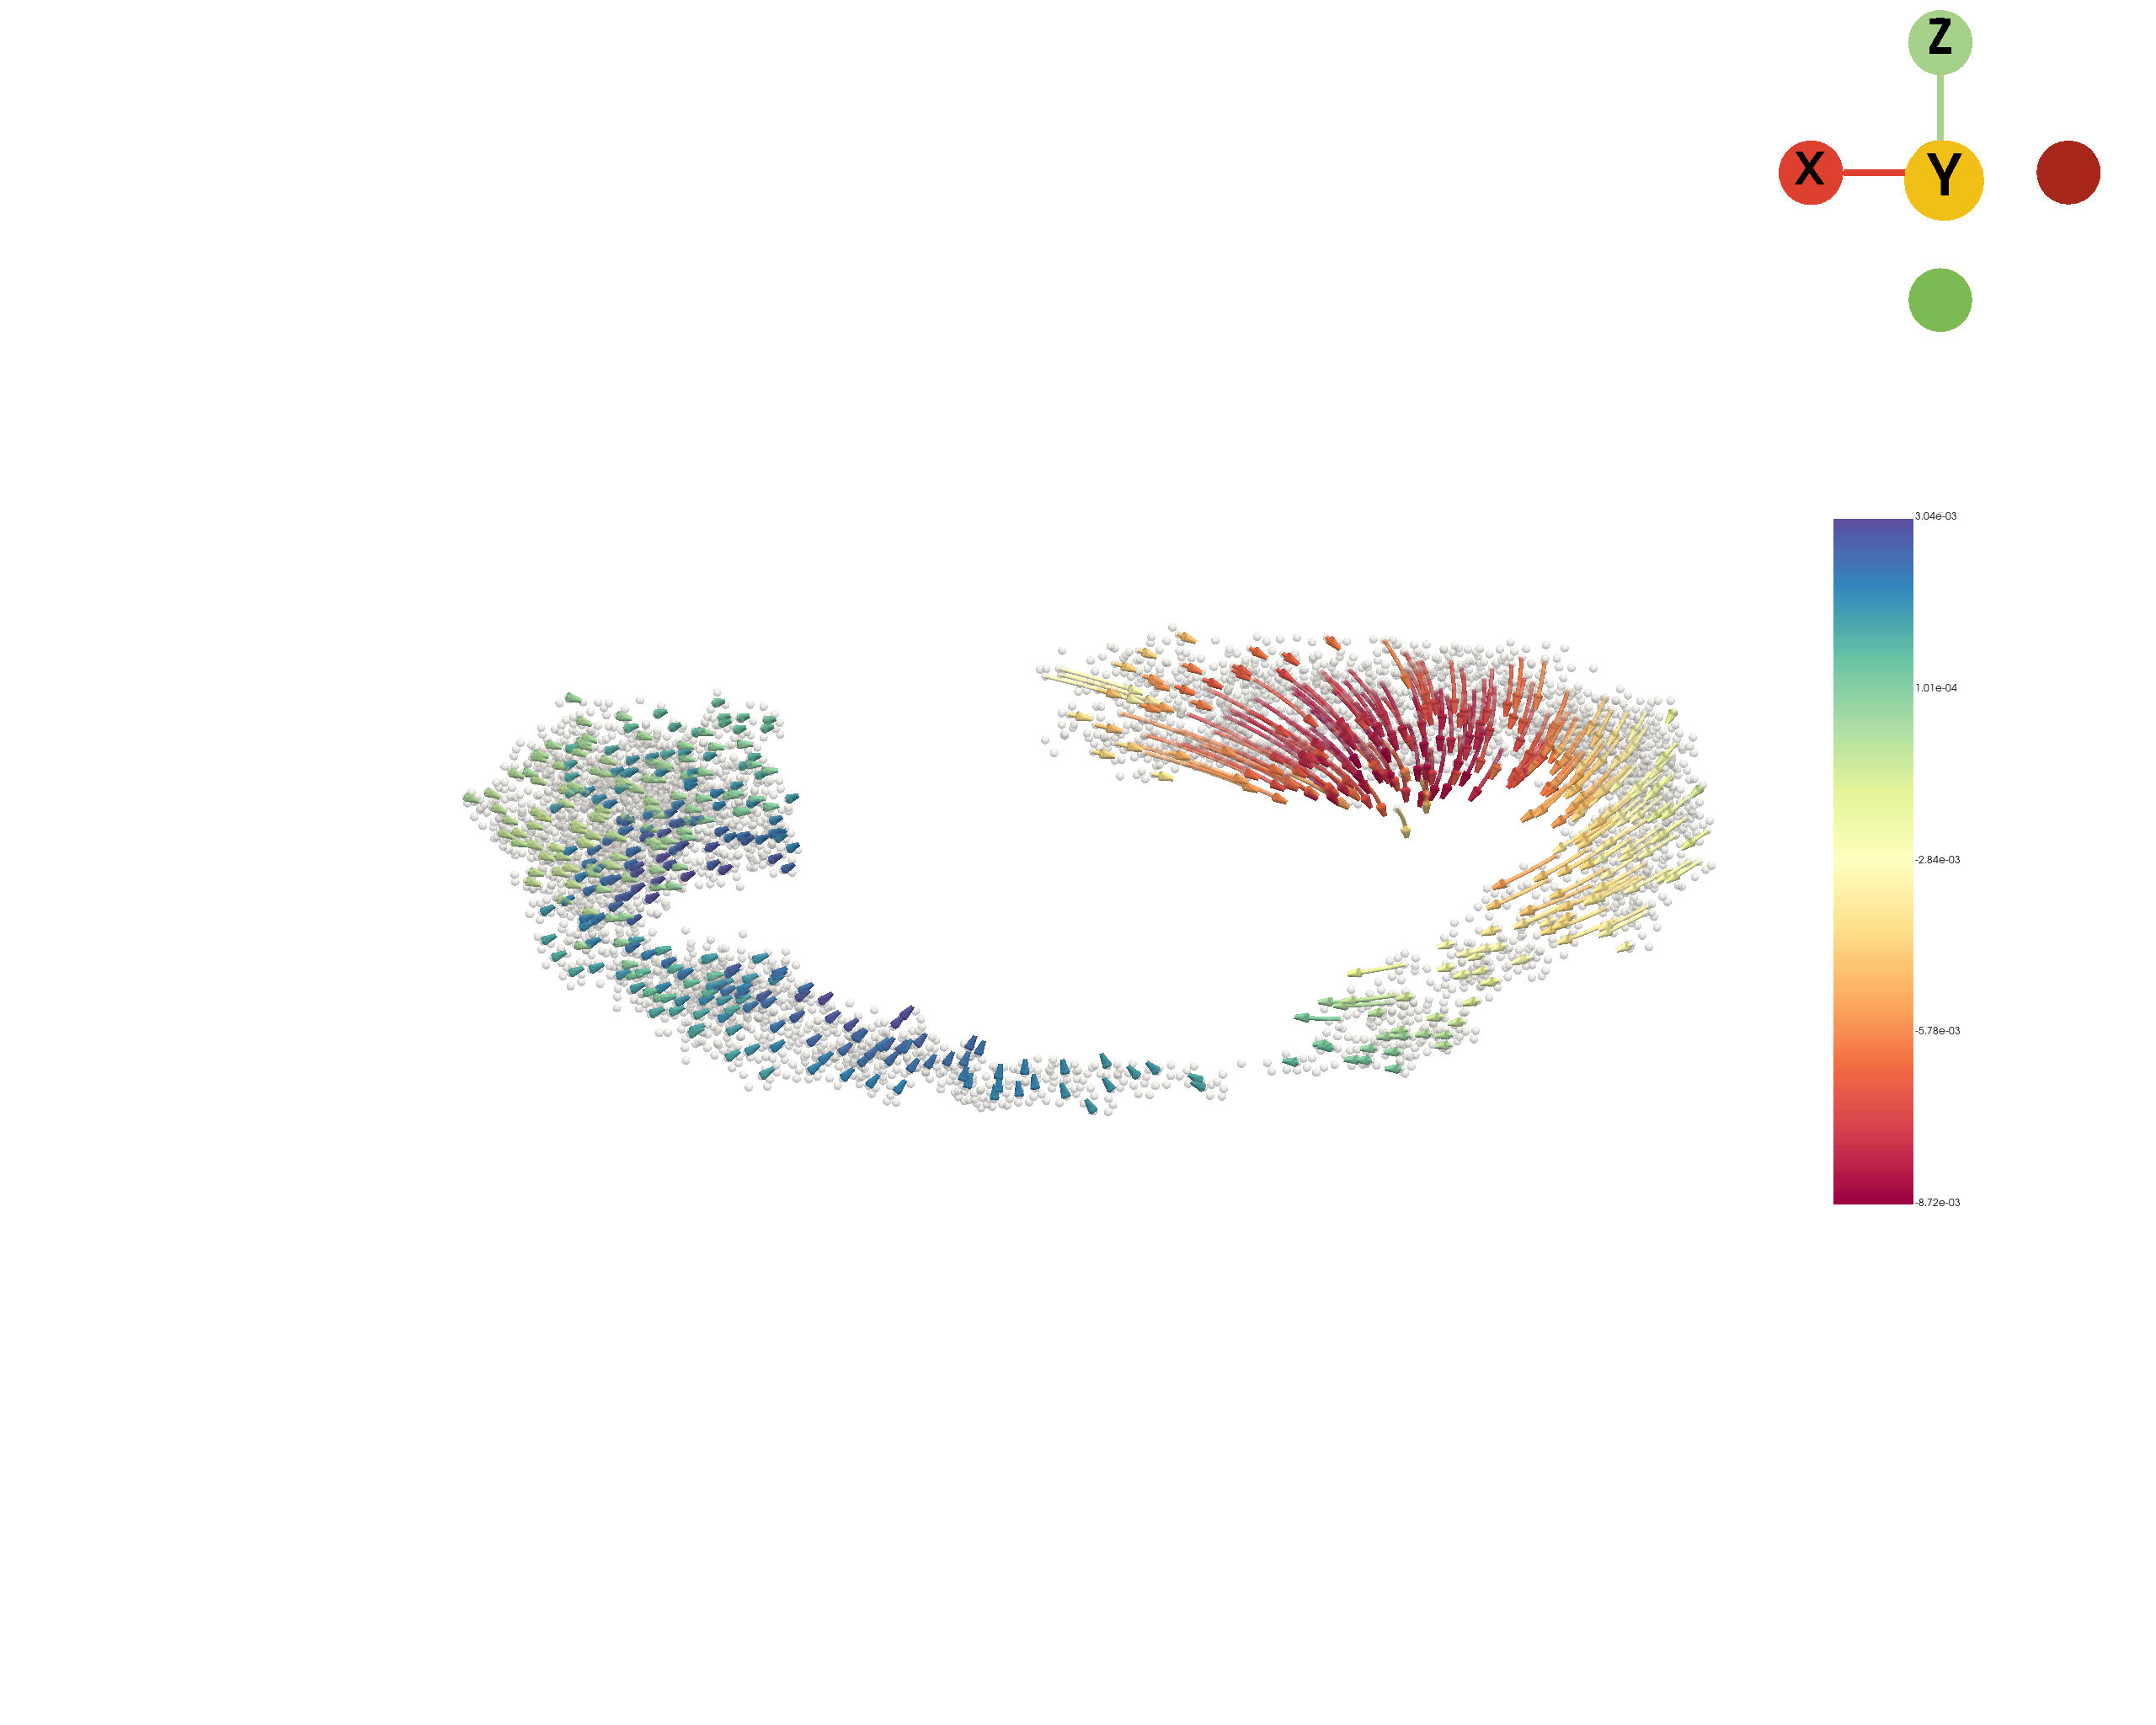

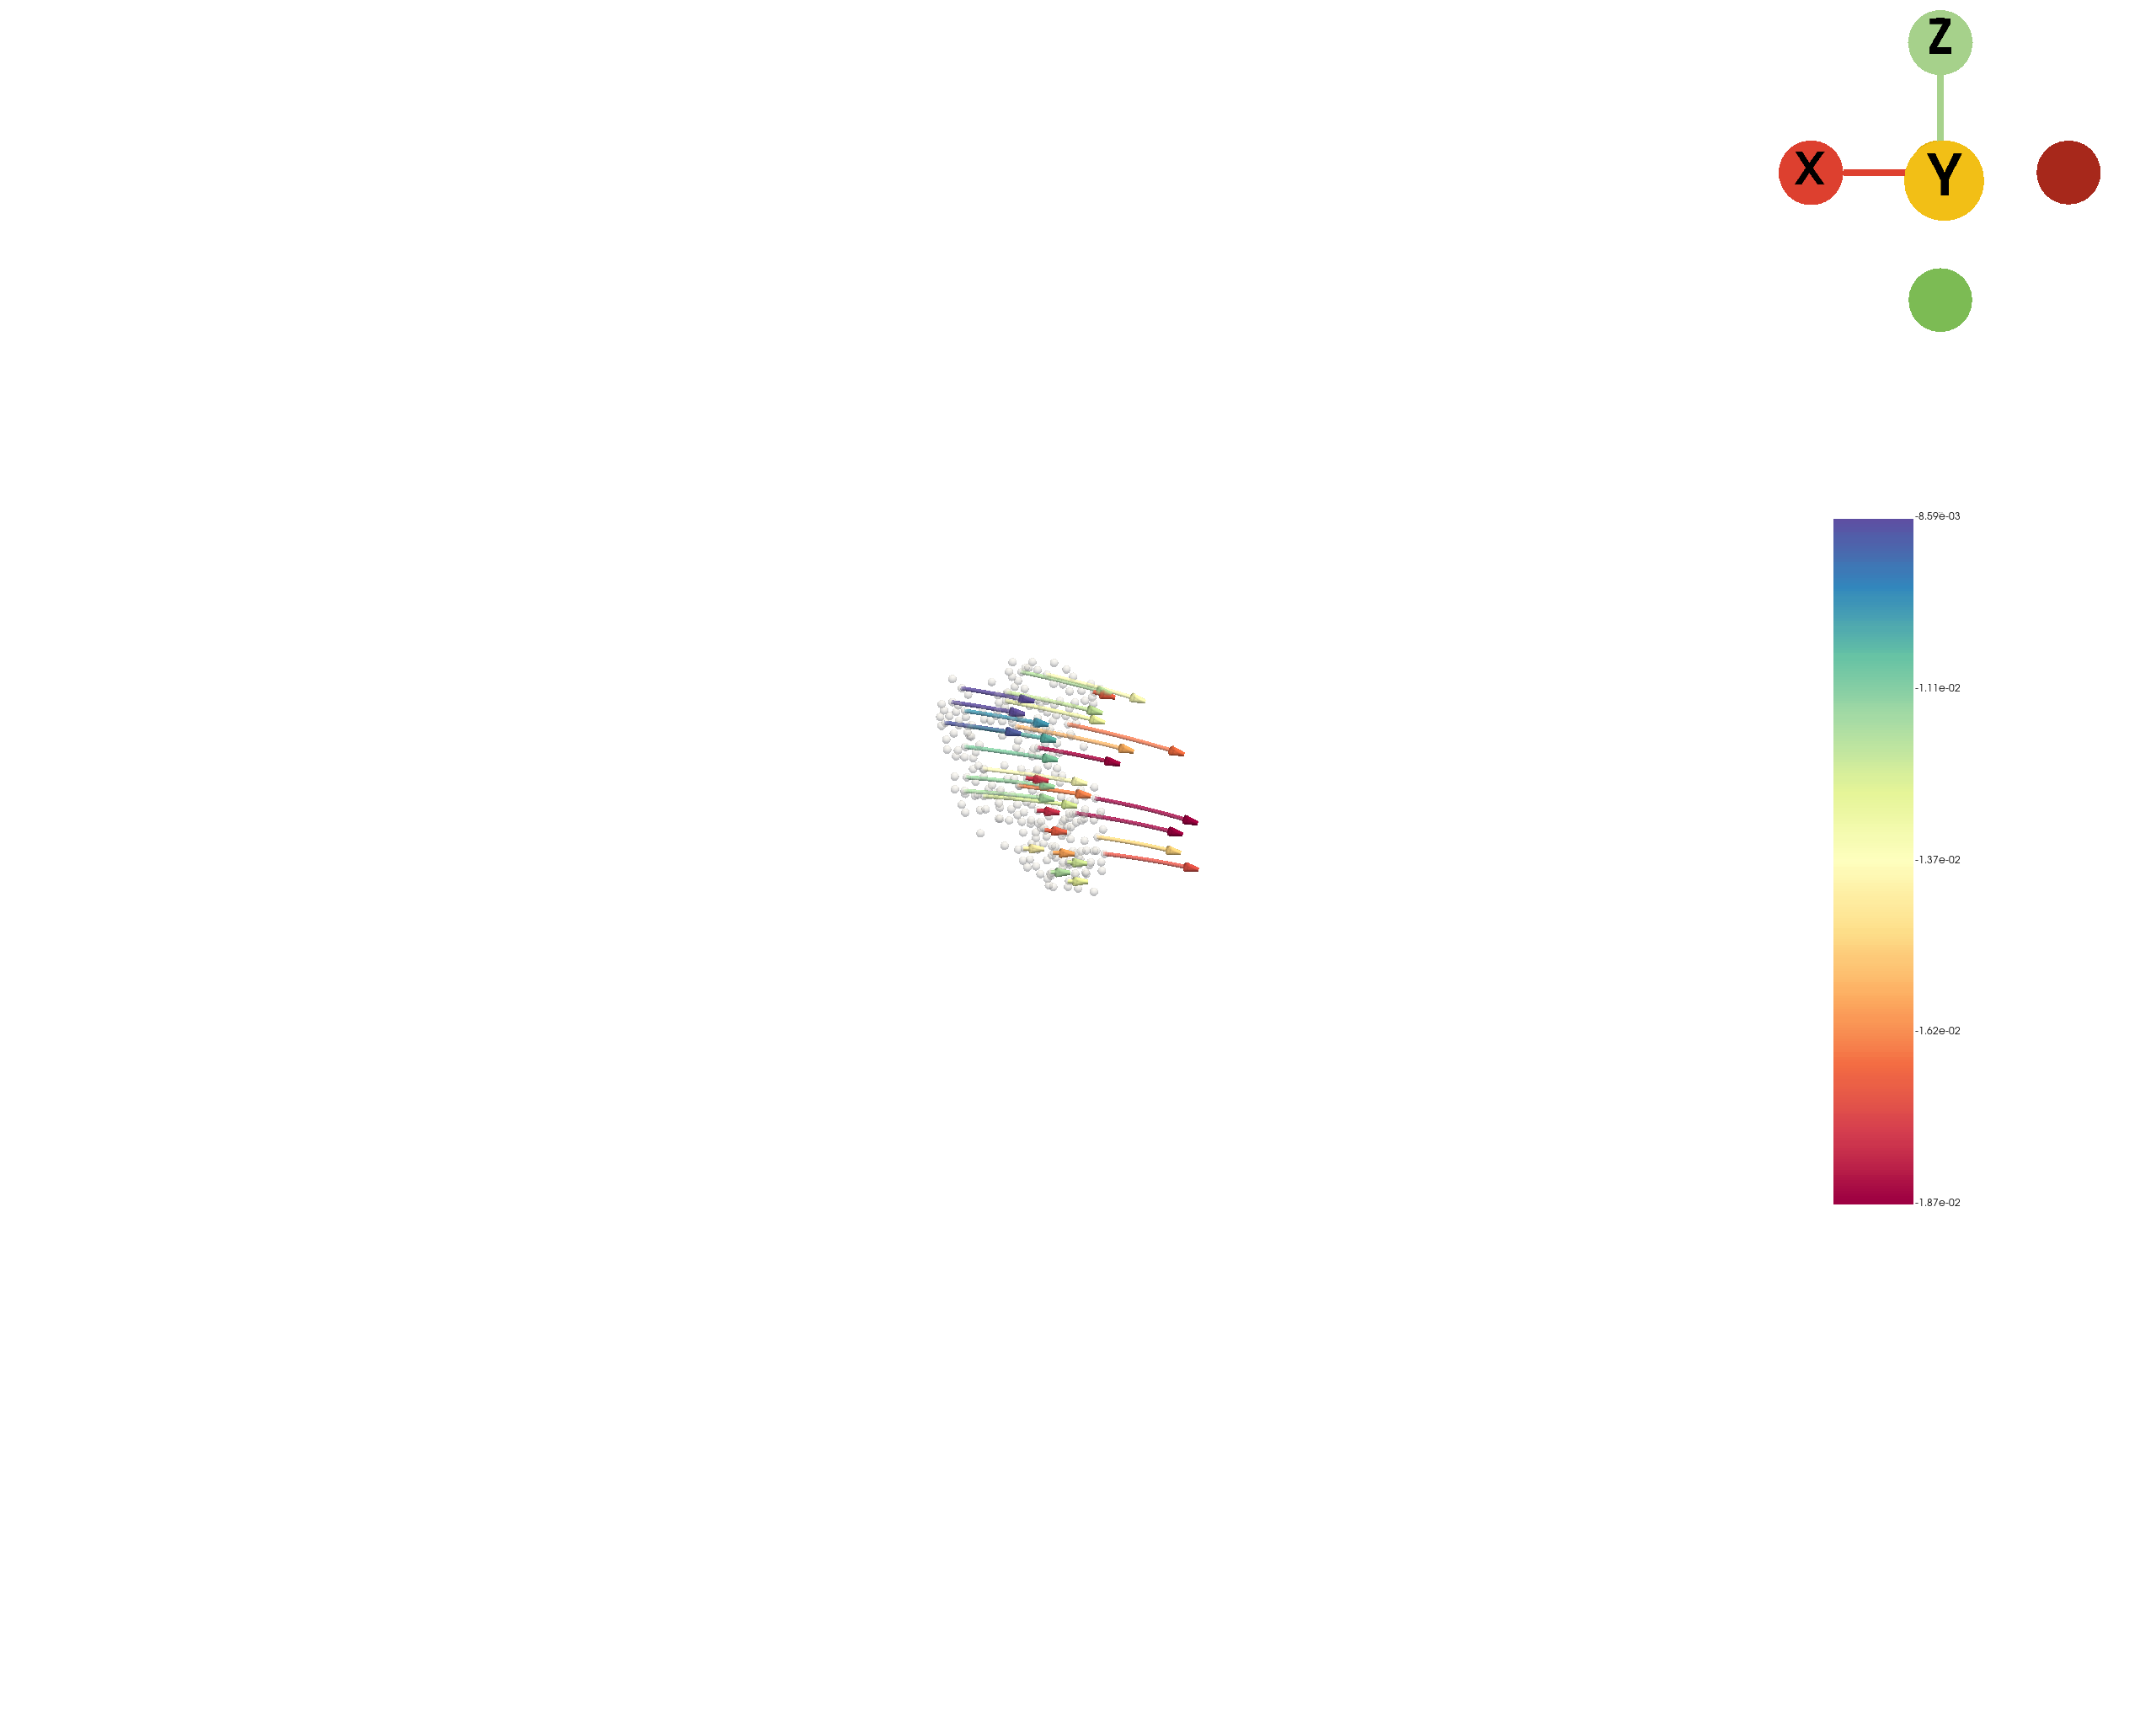

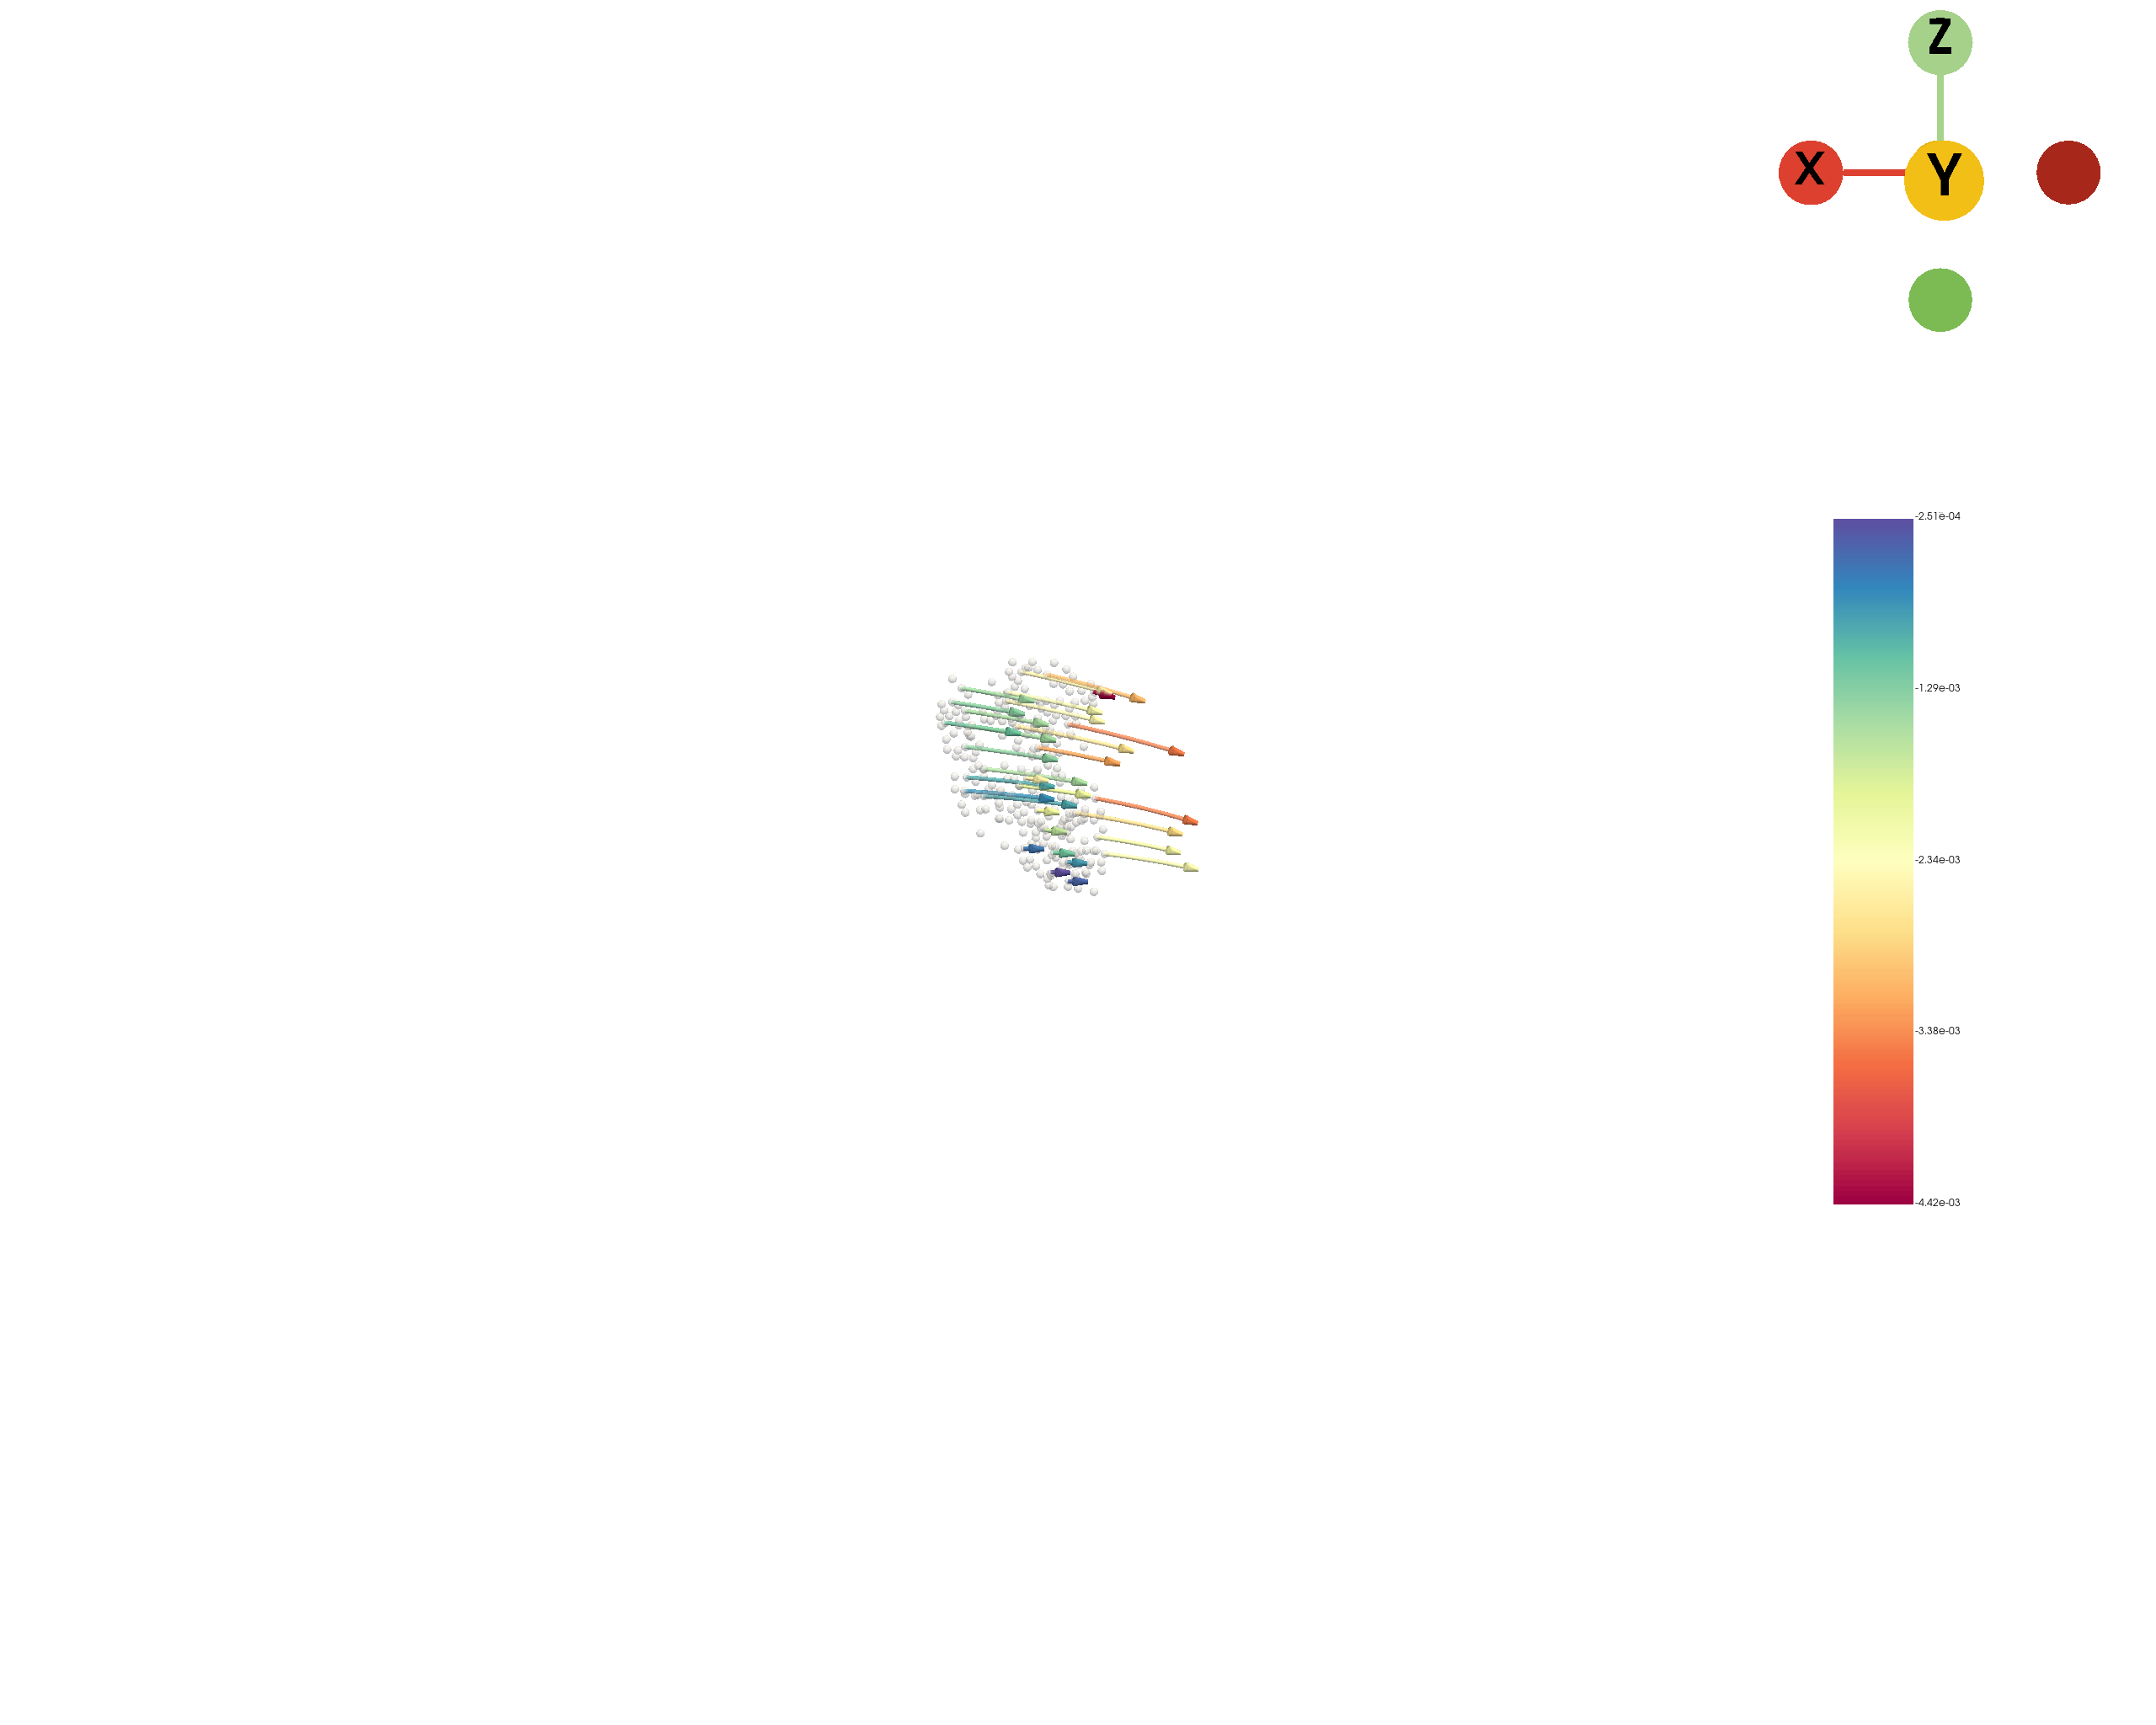

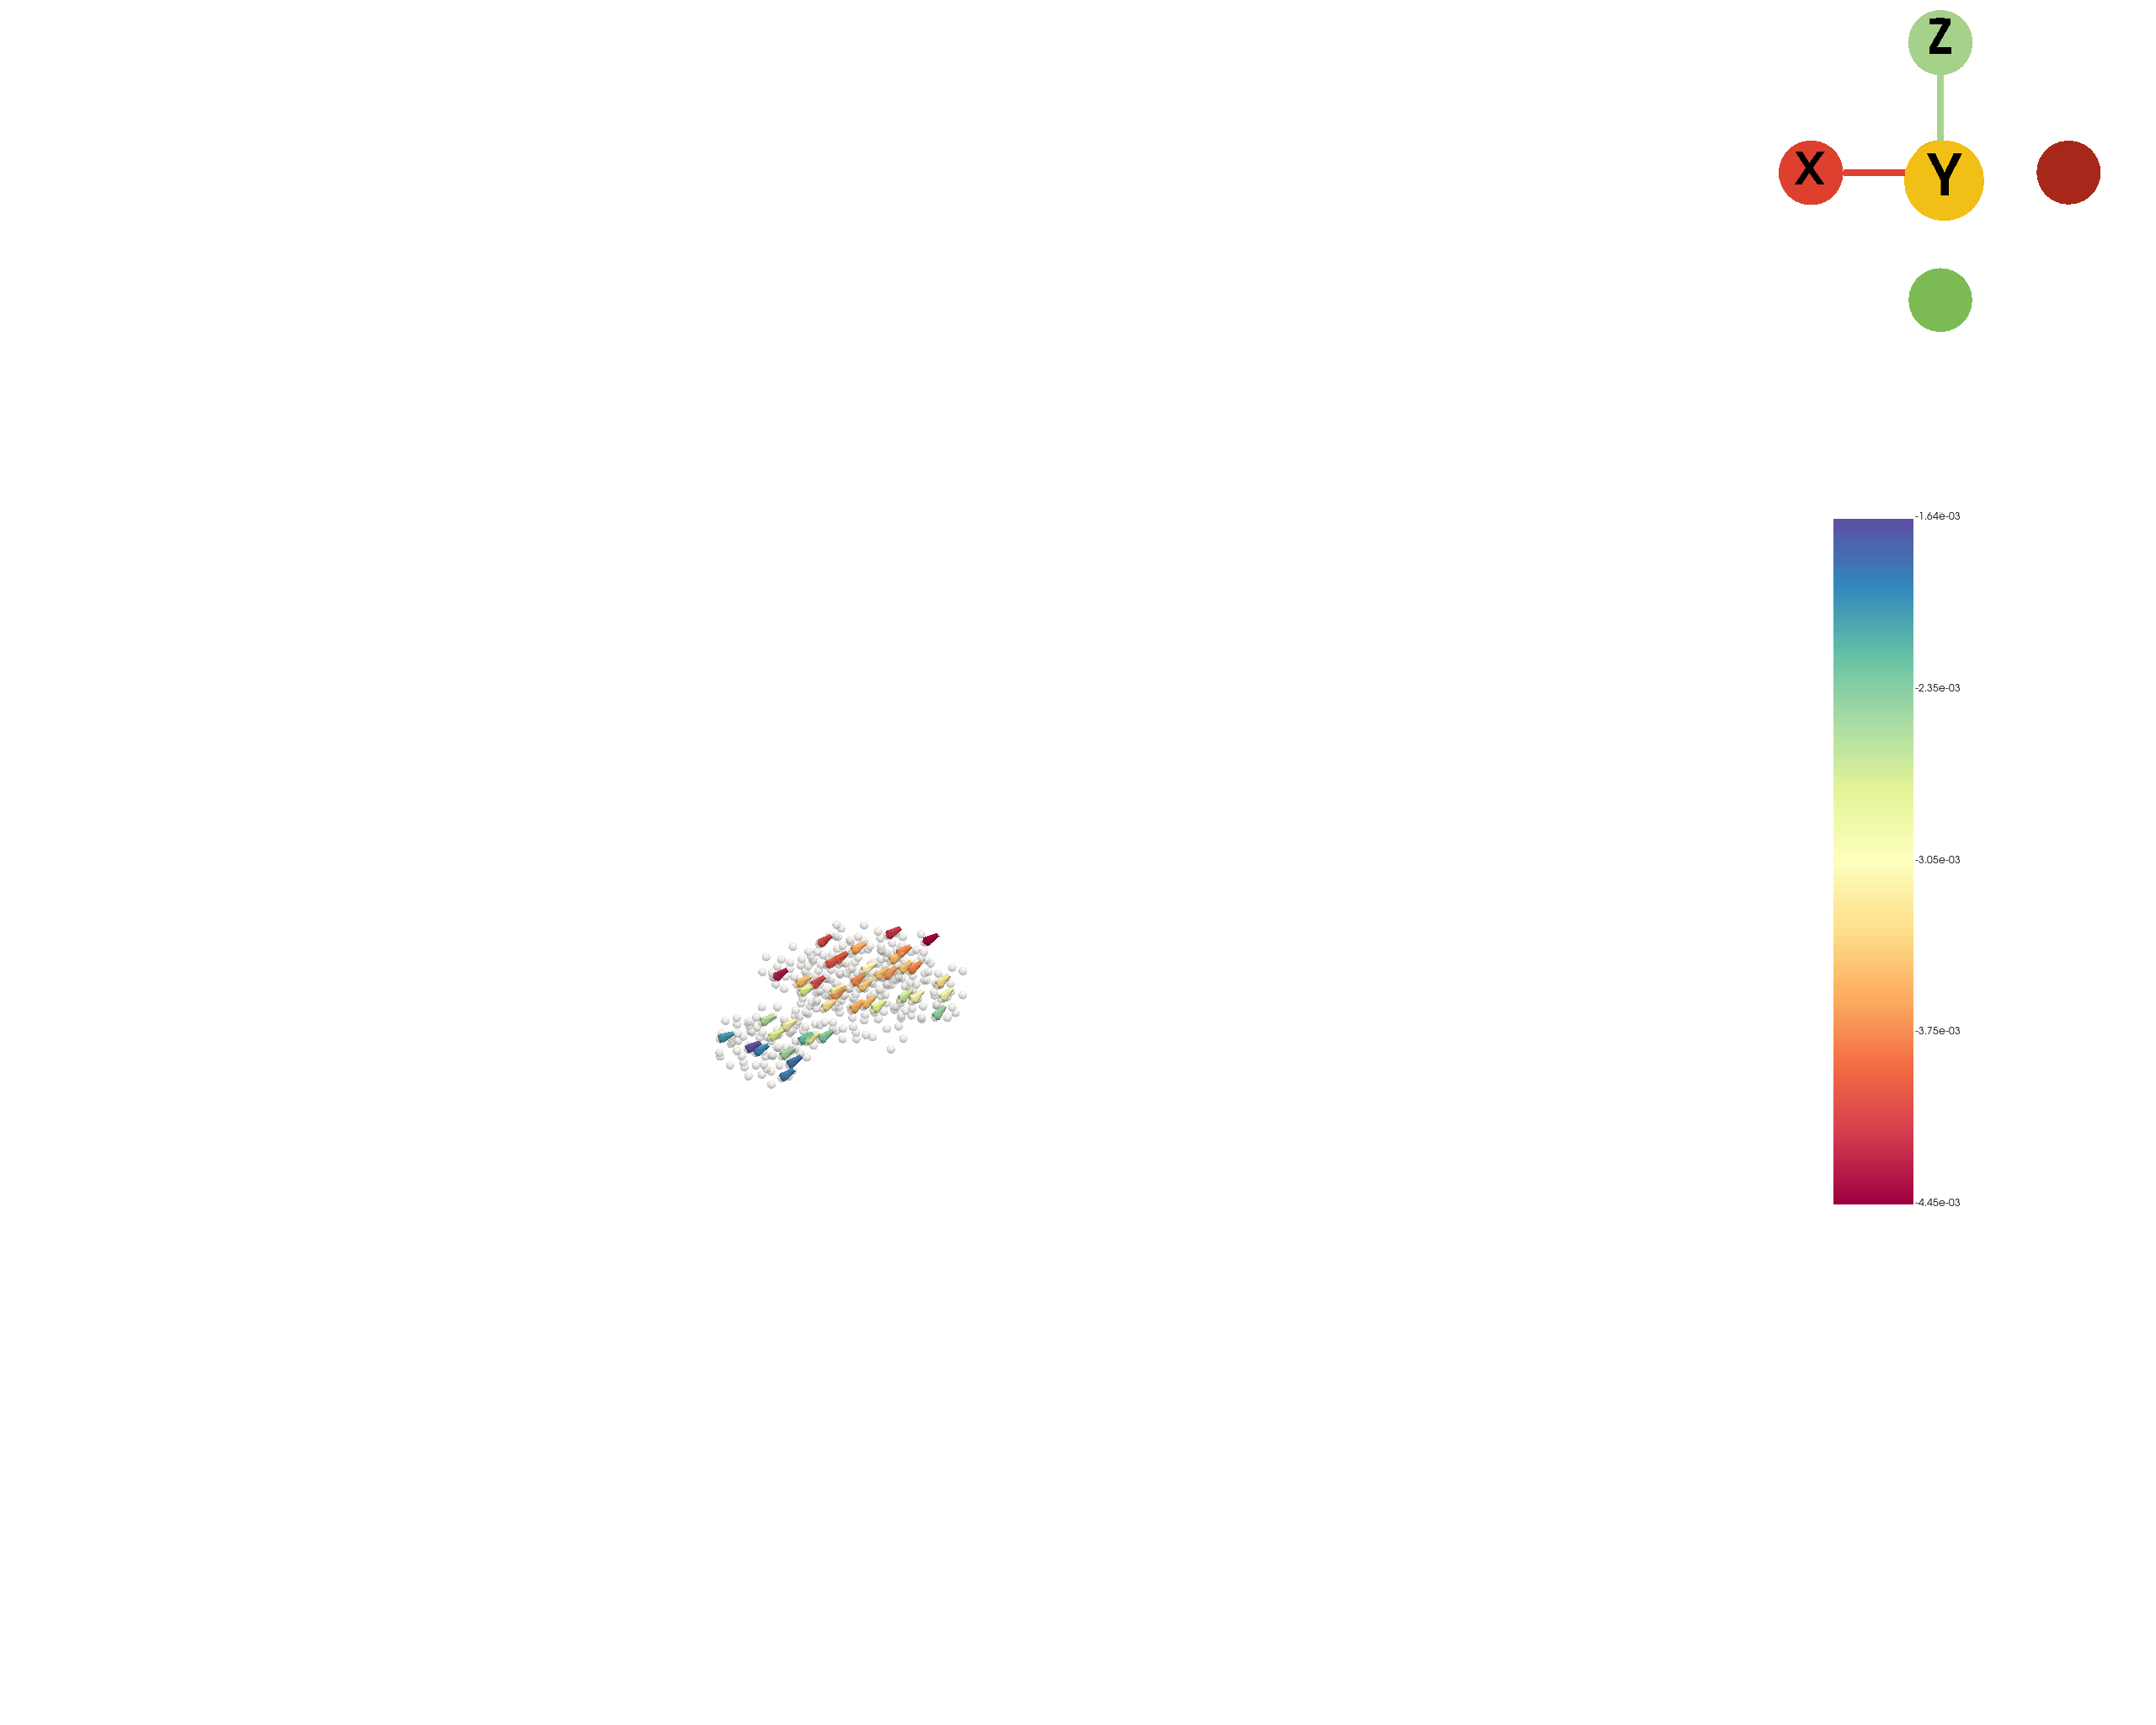

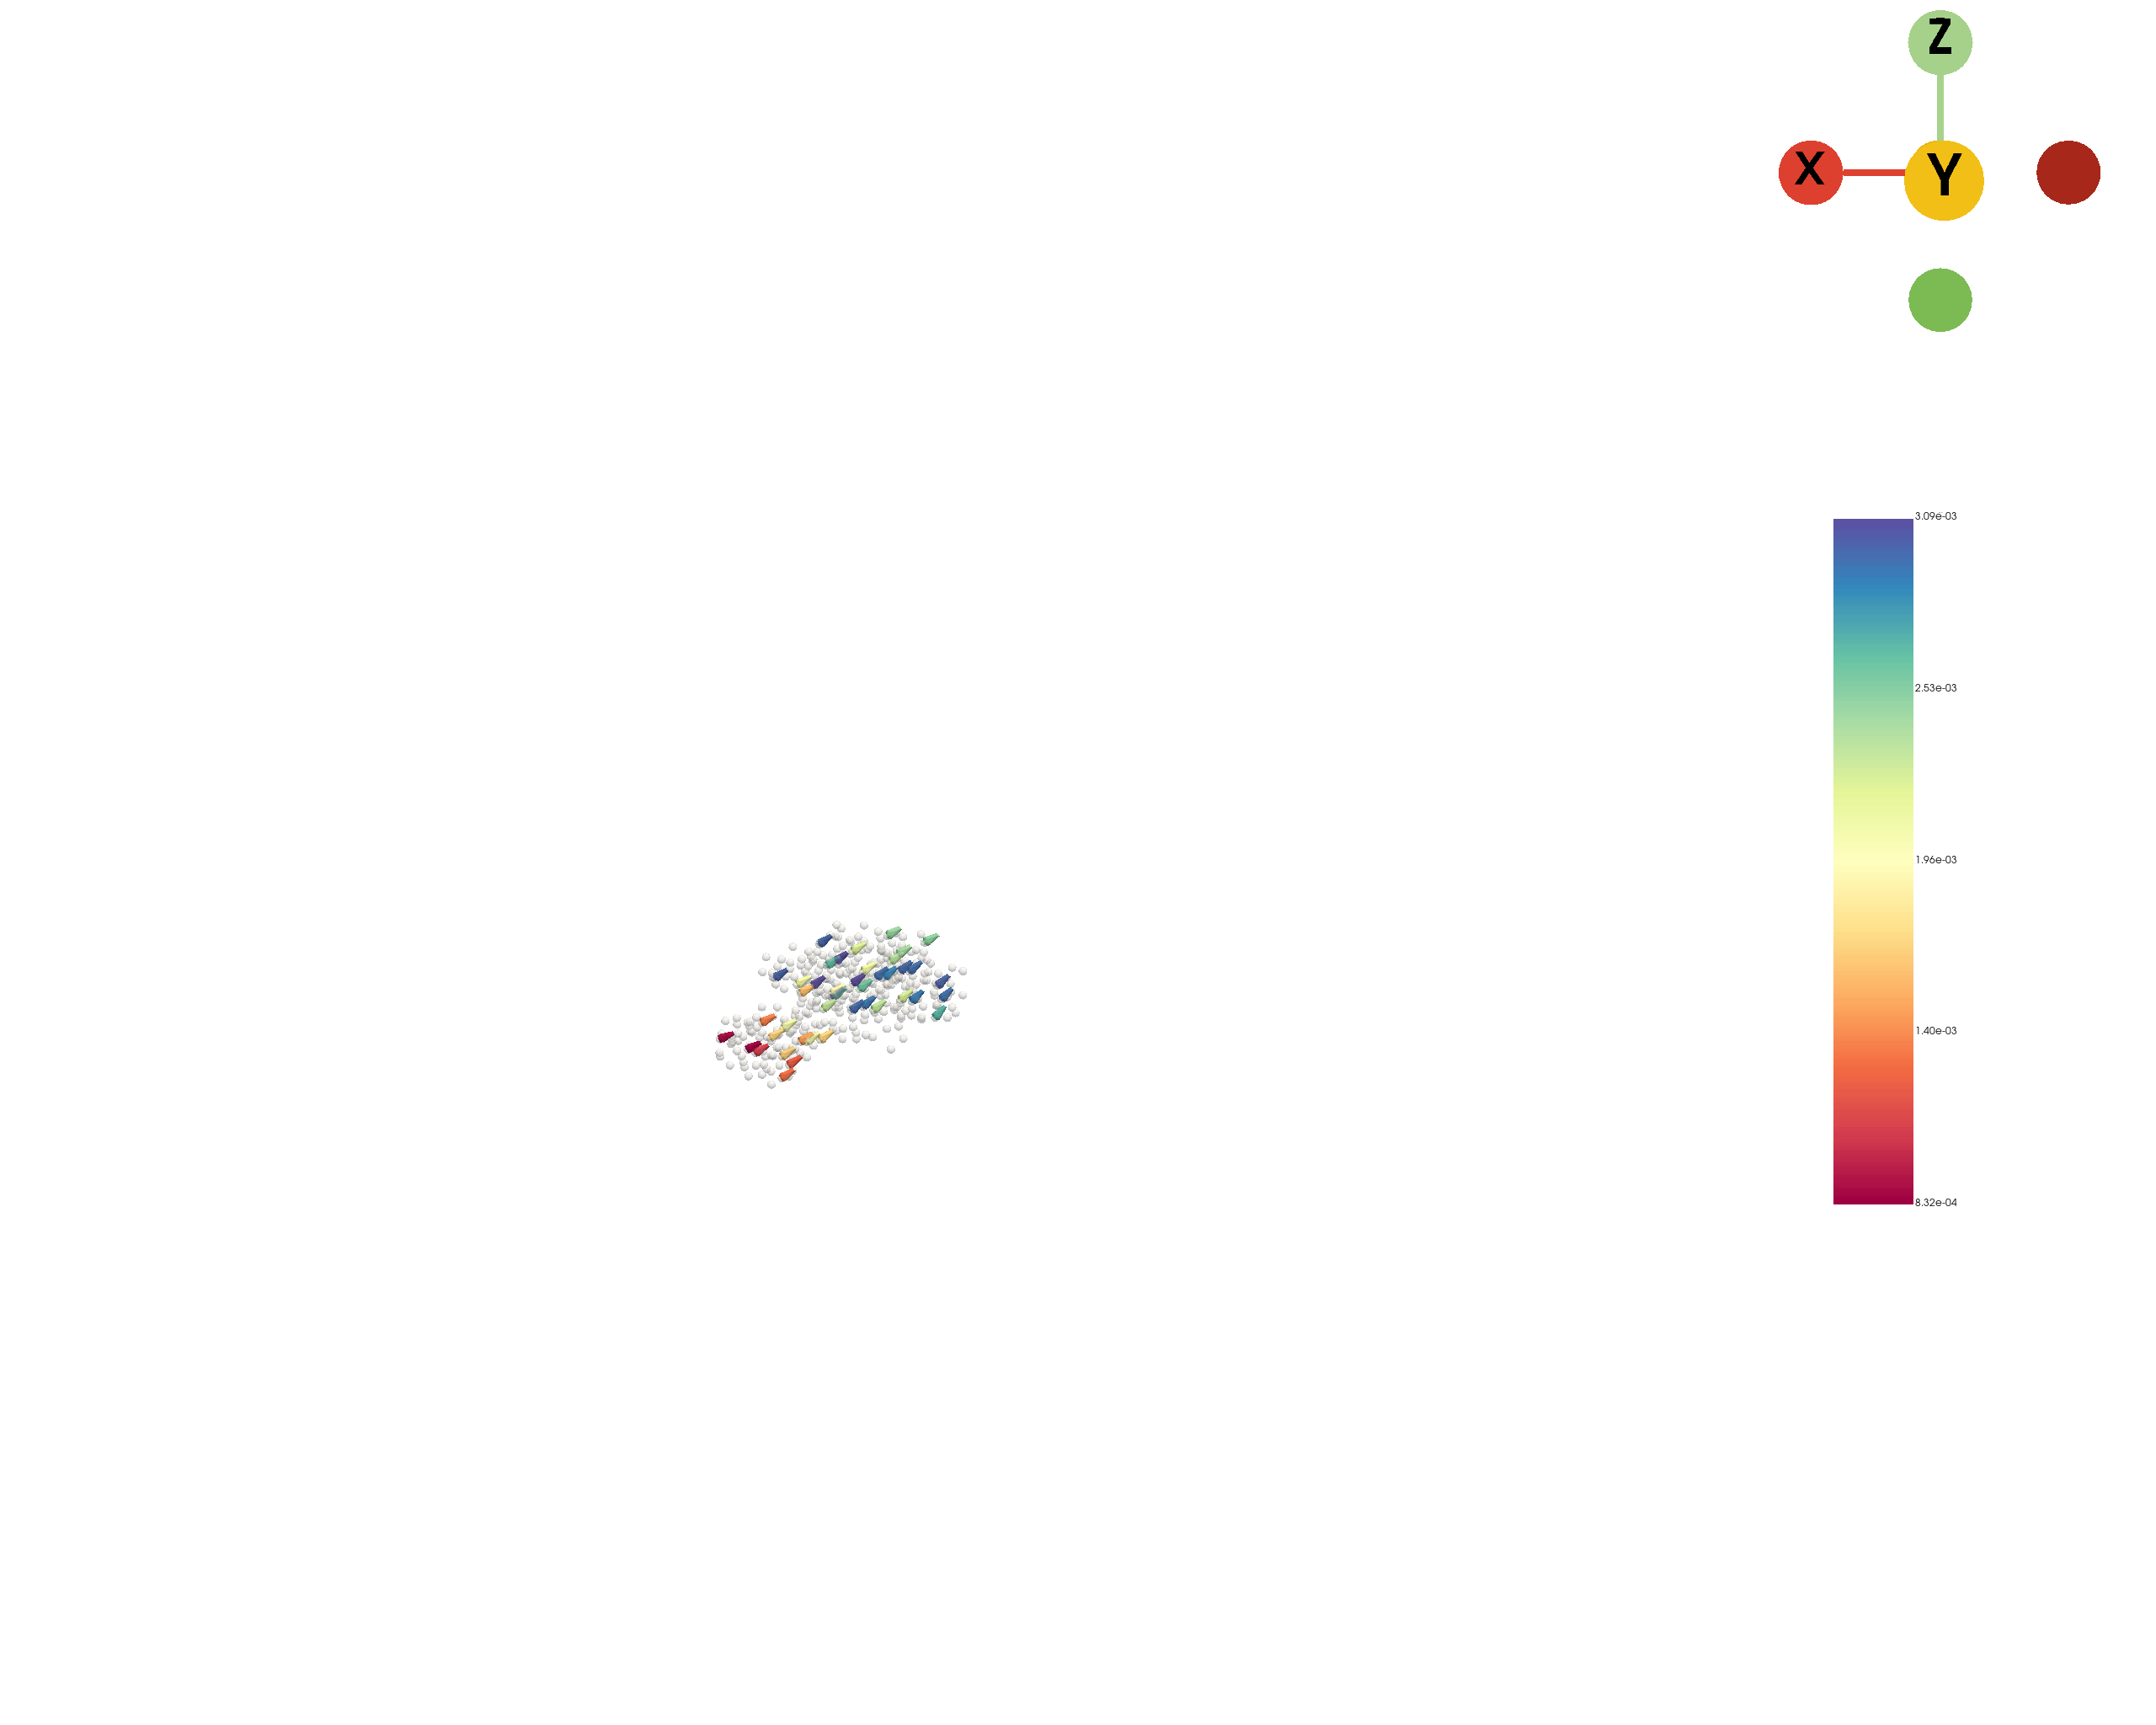

In [6]:
for tissue in ["midgut", "muscle", "CNS", "hindgut", "salivary gland"]:
    tissue_adata = germ_adata[germ_adata.obs["anno_tissue_new"] == tissue, :].copy()
    tissue_adata = tissue_adata[tissue_adata.layers["X_counts"].sum(axis=1) !=0, tissue_adata.layers["X_counts"].sum(axis=0) !=0]
    tissue_pc, _ = st.tdr.construct_pc(adata=tissue_adata, spatial_key="3d_align_spatial", groupby="anno_tissue_new", key_added="tissue",
                                       colormap={"CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "salivary gland": "#ef9b20"})
    tissue_trajectory_model = trajectory_model.extract_points(list(map(lambda x: x in tissue_adata.obs.index, np.asarray(trajectory_model.point_data["obs_index"]))))
    for k in ["V_x", "V_z"]:
        st.tdr.add_model_labels(
            model=tissue_trajectory_model,
            key_added="trajectory",
            labels=np.asarray(tissue_adata[np.asarray(tissue_trajectory_model.point_data["obs_index"])].obs[k]),
            where="point_data",
            inplace=True,
        )
        st.pl.three_d_plot(
            model=st.tdr.collect_models([tissue_pc, tissue_trajectory_model]),
            key=["tissue", "trajectory"],
            opacity=[0.5, .5],
            model_style=["points", "wireframe"],
            model_size=[10, 5],
            colormap=["gainsboro", "Spectral"],
            jupyter="static",
            background="white",
            window_size=(2560, 2048),
            cpo=cpo,
            filename=os.path.join(out_image_path, f"germband_morphofield_{tissue}_trajectory_pc_model_{k}.pdf")
        )
    